# Назва проекту: `Прогнозування продажів мережі роздрібних магазинів.`

## Підготував: `Гамаля Михайло`

#### Мережа `Rossmann` управляє понад 3000 магазинами в 7 країнах Європи. 
#### Продажі в магазині залежать від багатьох факторів, включаючи акції, конкуренцію, шкільні та державні свята, сезонність і місцевість. 
#### Датасет містить історичні дані про продажі для 1115 магазинів Rossmann за 3 роки. 
#### Завдання проекту – створити модель машинного навчання для прогнозування показника «Продажі» для даного датасету.

## `1. Збір та попередня обробка даних`

### Імпортуємо потрібні бібліотеки

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta

#Import Libries for graph
import matplotlib.pyplot as plt
import seaborn as sns

#Data Preparation
from sklearn.model_selection import train_test_split

#Import the Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor, train

#Cross Validation and Hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold

#import the metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, accuracy_score
from sklearn.metrics import r2_score, mean_absolute_percentage_error

import warnings
warnings.filterwarnings("ignore")

### Завантажуємо дані

In [2]:
# Перший файл - train.csv містить історичні дані про продажі мережі роздрібних магазинів

sales_data = pd.read_csv('Data/train.csv')
sales_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [3]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [4]:
# Другий файл - store.csv містить докладну інформацію про кожен магазин мережі

store_data = pd.read_csv('Data/store.csv')
store_data.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [5]:
store_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [6]:

# перевіряємо пропущені значення для sales_data
sales_data.isna().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [7]:
# перевіряємо пропущені значення для store_data
store_data.isna().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [8]:
# сортуємо sales_data за датою
sales_data = sales_data.sort_values('Date')

In [9]:
sales_data.describe(include='all')

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
count,1.017209e+06,1.017209e+06,1017209,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1017209,1.017209e+06
unique,NaN,NaN,942,NaN,NaN,NaN,NaN,5,NaN
top,NaN,NaN,2014-04-17,NaN,NaN,NaN,NaN,0,NaN
freq,NaN,NaN,1115,NaN,NaN,NaN,NaN,855087,NaN
mean,5.584297e+02,3.998341e+00,NaN,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,NaN,1.786467e-01
std,3.219087e+02,1.997391e+00,NaN,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,NaN,3.830564e-01
min,1.000000e+00,1.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00
25%,2.800000e+02,2.000000e+00,NaN,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,NaN,0.000000e+00
50%,5.580000e+02,4.000000e+00,NaN,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,NaN,0.000000e+00
75%,8.380000e+02,6.000000e+00,NaN,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,NaN,0.000000e+00


In [10]:
store_data.describe(include='all')

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
count,1115.00000,1115,1115,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000,571
unique,NaN,4,3,NaN,NaN,NaN,NaN,NaN,NaN,3
top,NaN,a,a,NaN,NaN,NaN,NaN,NaN,NaN,"Jan,Apr,Jul,Oct"
freq,NaN,602,593,NaN,NaN,NaN,NaN,NaN,NaN,335
mean,558.00000,NaN,NaN,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573,NaN
std,322.01708,NaN,NaN,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935,NaN
min,1.00000,NaN,NaN,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000,NaN
25%,279.50000,NaN,NaN,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000,NaN
50%,558.00000,NaN,NaN,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000,NaN
75%,836.50000,NaN,NaN,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000,NaN


#### Як ми бачимо, наша датасет складається з 2х файлів.

#### sales_data - містить 1017209 записів в 9 колонках - це продажі в 1115 магазинах мережі.
#### store_data - містить докладні дані про кожен з 1115 магазинів мережі в 10 колонках.

### Досліджуємо значення наших змінних по колонкам

* #### `Store` - унікальний ідентифікатор для кожного магазину
* #### `Sales` - сума продажів за кожен день
* #### `Customers` - кількість покупців за кожен день
* #### `Open` - індикатор того, чи був відкритий магазин: 0 = закрито, 1 = відкрито
* #### `StateHoliday` - вказує на державне свято. Зазвичай усі магазини, за невеликим винятком, закриті на державні свята. Зверніть увагу, що всі школи закриті у святкові та вихідні дні. a = державне свято, b = Великдень, c = Різдво, 0 = немає
* #### `SchoolHoliday` - вказує, чи вплинуло на (Магазин, Дата) закриття державних шкіл
* #### `StoreType` - існують 4 різні моделі магазинів: a, b, c, d
* #### `Assortment` - описує рівень асортименту: a = базовий, b = збільшений, c = розширений
* #### `CompetitionDistance` - відстань у метрах до найближчого магазину конкурента
* #### `CompetitionOpenSince` - дає приблизний рік і місяць відкриття найближчого конкурента
* #### `Promo` - вказує, чи в цей день магазин проводить рекламну акцію
* #### `Promo2` - це безперервна і послідовна акція для деяких магазинів: 0 = магазин не бере участь, 1 = магазин бере участь
* #### `Promo2Since` - описує рік і календарний тиждень, коли магазин почав брати участь в Promo2
* #### `PromoInterval` - описує послідовні інтервали запуску Promo2, називаючи місяці, коли акція запускається заново. наприклад "Feb,May,Aug,Nov" означає, що кожен раунд починається в лютому, травні, серпні, листопаді будь-якого року для цього магазину

In [11]:
for col in sales_data.columns:
  if col in ['Sales','Date']:
    continue
  else:
    print(f'Унікальні значення в стовпці {col} :',sales_data[col].unique())

Унікальні значення в стовпці Store : [1115  379  378 ...  745  739  988]
Унікальні значення в стовпці DayOfWeek : [2 3 4 5 6 7 1]
Унікальні значення в стовпці Customers : [   0  820  482 ... 4691 4783 3352]
Унікальні значення в стовпці Open : [0 1]
Унікальні значення в стовпці Promo : [0 1]
Унікальні значення в стовпці StateHoliday : ['a' '0' 'b' 'c' 0]
Унікальні значення в стовпці SchoolHoliday : [1 0]


In [12]:
for col in store_data.columns:
  if col in ['CompetitionDistance']:
    continue
  else:
    print(f'Унікальні значення в стовпці {col} :',store_data[col].unique())

Унікальні значення в стовпці Store : [   1    2    3 ... 1113 1114 1115]
Унікальні значення в стовпці StoreType : ['c' 'a' 'd' 'b']
Унікальні значення в стовпці Assortment : ['a' 'c' 'b']
Унікальні значення в стовпці CompetitionOpenSinceMonth : [ 9. 11. 12.  4. 10.  8. nan  3.  6.  5.  1.  2.  7.]
Унікальні значення в стовпці CompetitionOpenSinceYear : [2008. 2007. 2006. 2009. 2015. 2013. 2014. 2000. 2011.   nan 2010. 2005.
 1999. 2003. 2012. 2004. 2002. 1961. 1995. 2001. 1990. 1994. 1900. 1998.]
Унікальні значення в стовпці Promo2 : [0 1]
Унікальні значення в стовпці Promo2SinceWeek : [nan 13. 14.  1. 45. 40. 26. 22.  5.  6. 10. 31. 37.  9. 39. 27. 18. 35.
 23. 48. 36. 50. 44. 49. 28.]
Унікальні значення в стовпці Promo2SinceYear : [  nan 2010. 2011. 2012. 2009. 2014. 2015. 2013.]
Унікальні значення в стовпці PromoInterval : [nan 'Jan,Apr,Jul,Oct' 'Feb,May,Aug,Nov' 'Mar,Jun,Sept,Dec']


### Попереднє очищення даних

In [13]:
# Обраховуємо долю магазинів, які було відкрито після 2013 року
store_data[store_data.CompetitionOpenSinceYear >2013].shape[0]/store_data[store_data.CompetitionOpenSinceYear <2013].shape[0]

0.18947368421052632

* #### Ми маємо 354 пропущених значень із 1115 (32%) та долю магазинів конкурентів, по ненульовим даним, які було відкрито до початку наших історичних даних по продажам (81%). Виходячи з цього ми можемо знехтувати даними в цих стовбчиках.

In [14]:
#Видаляємо колонки 'CompetitionOpenSinceYear','CompetitionOpenSinceMonth'
store_data.drop(['CompetitionOpenSinceYear','CompetitionOpenSinceMonth'],axis=1,inplace=True)

In [15]:
# Пропущені значення в колонці CompetitionDistance	
store_data[store_data.CompetitionDistance.isnull()]

,Store,StoreType,Assortment,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [16]:
# Заповнюємо ці пропущені значення середніми значеннями
store_data.CompetitionDistance.fillna(value = store_data.CompetitionDistance.mean(), inplace = True)

##### Promo2SinceWeek
##### Promo2SinceYear
##### PromoInterval

In [17]:
# перевіряємо пропущені значення для store_data
store_data.isna().sum()

Store                    0
StoreType                0
Assortment               0
CompetitionDistance      0
Promo2                   0
Promo2SinceWeek        544
Promo2SinceYear        544
PromoInterval          544
dtype: int64

In [18]:
store_data[store_data.Promo2==0].isna().sum()

Store                    0
StoreType                0
Assortment               0
CompetitionDistance      0
Promo2                   0
Promo2SinceWeek        544
Promo2SinceYear        544
PromoInterval          544
dtype: int64

* #### Як бачимо, пропущені дані в колонках Promo2SinceWeek, Promo2SinceYear, PromoInterval - це ті дані, де Promo2=0

In [19]:
# Визначаємо максимальну дату в наших історичних даних
sales_data.Date = pd.to_datetime(sales_data.Date)
print(sales_data.Date.max())
print(sales_data.Date.max().year)
print(sales_data.Date.max().week)

2015-07-31 00:00:00
2015
31


In [20]:
#Міняємо пропущені дані в колонках Promo2SinceWeek, Promo2SinceYear на максимальну дату в датасеті
store_data.Promo2SinceYear.fillna(value = (sales_data.Date.max().year),inplace=True)
store_data.Promo2SinceWeek.fillna(value = (sales_data.Date.max().week),inplace=True)
store_data.isnull().sum()

Store                    0
StoreType                0
Assortment               0
CompetitionDistance      0
Promo2                   0
Promo2SinceWeek          0
Promo2SinceYear          0
PromoInterval          544
dtype: int64

In [21]:
#Міняємо пропущені значення в колонці PromoInterval на None
store_data.PromoInterval.fillna(value = 'None',inplace=True)
store_data.isnull().sum()

Store                  0
StoreType              0
Assortment             0
CompetitionDistance    0
Promo2                 0
Promo2SinceWeek        0
Promo2SinceYear        0
PromoInterval          0
dtype: int64

In [22]:
#Функція для отримання дати
def get_date(year,week):
  year = int(year)
  week = int(week)
  date = dt.date(year, 1, 1) + relativedelta(weeks=+week)
  return(date)

In [23]:
# Створення стовпця дати за допомогою стовпців Promo2SinceWeek, Promo2SinceYear
store_data['promo2_start_date'] = store_data.apply(lambda x: get_date(x.Promo2SinceYear,x.Promo2SinceWeek),axis=1)

In [24]:
# Тепер ми можемо видалити колонки 'Promo2','Promo2SinceWeek','Promo2SinceYear' оскільки ми створили колонку 'promo2_start_date'
store_data.drop(['Promo2','Promo2SinceWeek','Promo2SinceYear'],axis=1,inplace=True)

### Для подальшого аналізу об'єднаємо наші 2 файли по спільному полю Store

In [25]:
df = sales_data.merge(store_data, how='outer', on='Store')
df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,PromoInterval,promo2_start_date
0,1115,2,2013-01-01,0,0,0,0,a,1,d,c,5350.0,"Mar,Jun,Sept,Dec",2012-06-03
1,1115,3,2013-01-02,3697,305,1,0,0,1,d,c,5350.0,"Mar,Jun,Sept,Dec",2012-06-03
2,1115,4,2013-01-03,4297,300,1,0,0,1,d,c,5350.0,"Mar,Jun,Sept,Dec",2012-06-03
3,1115,5,2013-01-04,4540,326,1,0,0,1,d,c,5350.0,"Mar,Jun,Sept,Dec",2012-06-03
4,1115,6,2013-01-05,4771,339,1,0,0,1,d,c,5350.0,"Mar,Jun,Sept,Dec",2012-06-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,988,1,2015-07-27,6011,812,1,1,0,1,a,a,30.0,None,2015-08-06
1017205,988,2,2015-07-28,4592,705,1,1,0,1,a,a,30.0,None,2015-08-06
1017206,988,3,2015-07-29,4522,689,1,1,0,1,a,a,30.0,None,2015-08-06
1017207,988,4,2015-07-30,4591,673,1,1,0,1,a,a,30.0,None,2015-08-06


In [26]:
# Докладна інформація по нашому датасету
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 14 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   Store                1017209 non-null  int64         
 1   DayOfWeek            1017209 non-null  int64         
 2   Date                 1017209 non-null  datetime64[ns]
 3   Sales                1017209 non-null  int64         
 4   Customers            1017209 non-null  int64         
 5   Open                 1017209 non-null  int64         
 6   Promo                1017209 non-null  int64         
 7   StateHoliday         1017209 non-null  object        
 8   SchoolHoliday        1017209 non-null  int64         
 9   StoreType            1017209 non-null  object        
 10  Assortment           1017209 non-null  object        
 11  CompetitionDistance  1017209 non-null  float64       
 12  PromoInterval        1017209 non-null  object        
 1

In [27]:
# Перевіряємо наявність дублікатів в нашому датасеті
duplicate_rows_in_store_data = df.duplicated().sum()
print('Кількість дублікатів в датасеті:',duplicate_rows_in_store_data)

Кількість дублікатів в датасеті: 0


In [28]:
# Визначаємо та рахуємо пропущені значення по колонкам
print(df.isnull().sum())

Store                  0
DayOfWeek              0
Date                   0
Sales                  0
Customers              0
Open                   0
Promo                  0
StateHoliday           0
SchoolHoliday          0
StoreType              0
Assortment             0
CompetitionDistance    0
PromoInterval          0
promo2_start_date      0
dtype: int64


In [29]:
#конвертуємо дані з датою в формат datetime
df.Date = pd.to_datetime(df.Date)
df.promo2_start_date = pd.to_datetime(df.promo2_start_date)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 14 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   Store                1017209 non-null  int64         
 1   DayOfWeek            1017209 non-null  int64         
 2   Date                 1017209 non-null  datetime64[ns]
 3   Sales                1017209 non-null  int64         
 4   Customers            1017209 non-null  int64         
 5   Open                 1017209 non-null  int64         
 6   Promo                1017209 non-null  int64         
 7   StateHoliday         1017209 non-null  object        
 8   SchoolHoliday        1017209 non-null  int64         
 9   StoreType            1017209 non-null  object        
 10  Assortment           1017209 non-null  object        
 11  CompetitionDistance  1017209 non-null  float64       
 12  PromoInterval        1017209 non-null  object        
 1

In [30]:
# Створюємо нову колонку, яка показує чи активне Promo2
df['Promo2_active'] = np.where(df['Date'] >= df['promo2_start_date'], 1 , 0)
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,PromoInterval,promo2_start_date,Promo2_active
0,1115,2,2013-01-01,0,0,0,0,a,1,d,c,5350.0,"Mar,Jun,Sept,Dec",2012-06-03,1
1,1115,3,2013-01-02,3697,305,1,0,0,1,d,c,5350.0,"Mar,Jun,Sept,Dec",2012-06-03,1
2,1115,4,2013-01-03,4297,300,1,0,0,1,d,c,5350.0,"Mar,Jun,Sept,Dec",2012-06-03,1
3,1115,5,2013-01-04,4540,326,1,0,0,1,d,c,5350.0,"Mar,Jun,Sept,Dec",2012-06-03,1
4,1115,6,2013-01-05,4771,339,1,0,0,1,d,c,5350.0,"Mar,Jun,Sept,Dec",2012-06-03,1


In [31]:
# Тепер колонку promo2_start_date можемо видалити
df.drop(columns = ['promo2_start_date'], axis=1,inplace= True)
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,PromoInterval,Promo2_active
0,1115,2,2013-01-01,0,0,0,0,a,1,d,c,5350.0,"Mar,Jun,Sept,Dec",1
1,1115,3,2013-01-02,3697,305,1,0,0,1,d,c,5350.0,"Mar,Jun,Sept,Dec",1
2,1115,4,2013-01-03,4297,300,1,0,0,1,d,c,5350.0,"Mar,Jun,Sept,Dec",1
3,1115,5,2013-01-04,4540,326,1,0,0,1,d,c,5350.0,"Mar,Jun,Sept,Dec",1
4,1115,6,2013-01-05,4771,339,1,0,0,1,d,c,5350.0,"Mar,Jun,Sept,Dec",1


In [32]:
# Виведемо унікальні значення поля StateHoliday
print(df['StateHoliday'].unique())

['a' '0' 'b' 'c' 0]


In [33]:
# Як бачимо, датасет містить 2 типи значення 0, тому їх потрібно привести до одного типу
df['StateHoliday'].replace({'0':0}, inplace=True)
print(df['StateHoliday'].unique())

['a' 0 'b' 'c']


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 14 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   Store                1017209 non-null  int64         
 1   DayOfWeek            1017209 non-null  int64         
 2   Date                 1017209 non-null  datetime64[ns]
 3   Sales                1017209 non-null  int64         
 4   Customers            1017209 non-null  int64         
 5   Open                 1017209 non-null  int64         
 6   Promo                1017209 non-null  int64         
 7   StateHoliday         1017209 non-null  object        
 8   SchoolHoliday        1017209 non-null  int64         
 9   StoreType            1017209 non-null  object        
 10  Assortment           1017209 non-null  object        
 11  CompetitionDistance  1017209 non-null  float64       
 12  PromoInterval        1017209 non-null  object        
 1

### Отже ми провели попередню обробку наших даних та об'єднали дані з 2х файлів для подальшої ретельної обробки та аналізу.

## `2. Дослідження даних`

#### Наш датасет складається з 2х частин - це тещо ми будемо прогнозувати (Sales) та всі інші дані. 
#### Для візуалізації залежності між нашими елементами будуємо теплову карту.

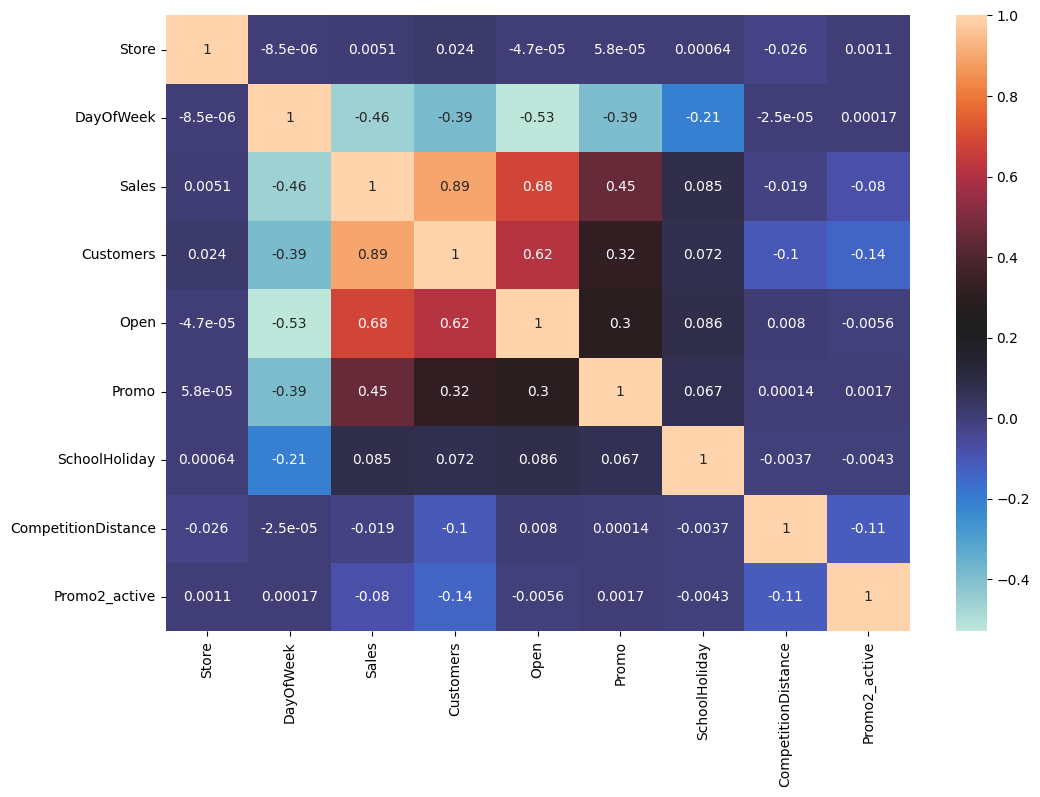

In [35]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(),cmap='icefire', annot=True)
plt.show()

array([[<AxesSubplot: title={'center': 'Store'}>,
        <AxesSubplot: title={'center': 'DayOfWeek'}>,
        <AxesSubplot: title={'center': 'Date'}>],
       [<AxesSubplot: title={'center': 'Sales'}>,
        <AxesSubplot: title={'center': 'Customers'}>,
        <AxesSubplot: title={'center': 'Open'}>],
       [<AxesSubplot: title={'center': 'Promo'}>,
        <AxesSubplot: title={'center': 'SchoolHoliday'}>,
        <AxesSubplot: title={'center': 'CompetitionDistance'}>],
       [<AxesSubplot: title={'center': 'Promo2_active'}>,
        <AxesSubplot: >, <AxesSubplot: >]], dtype=object)

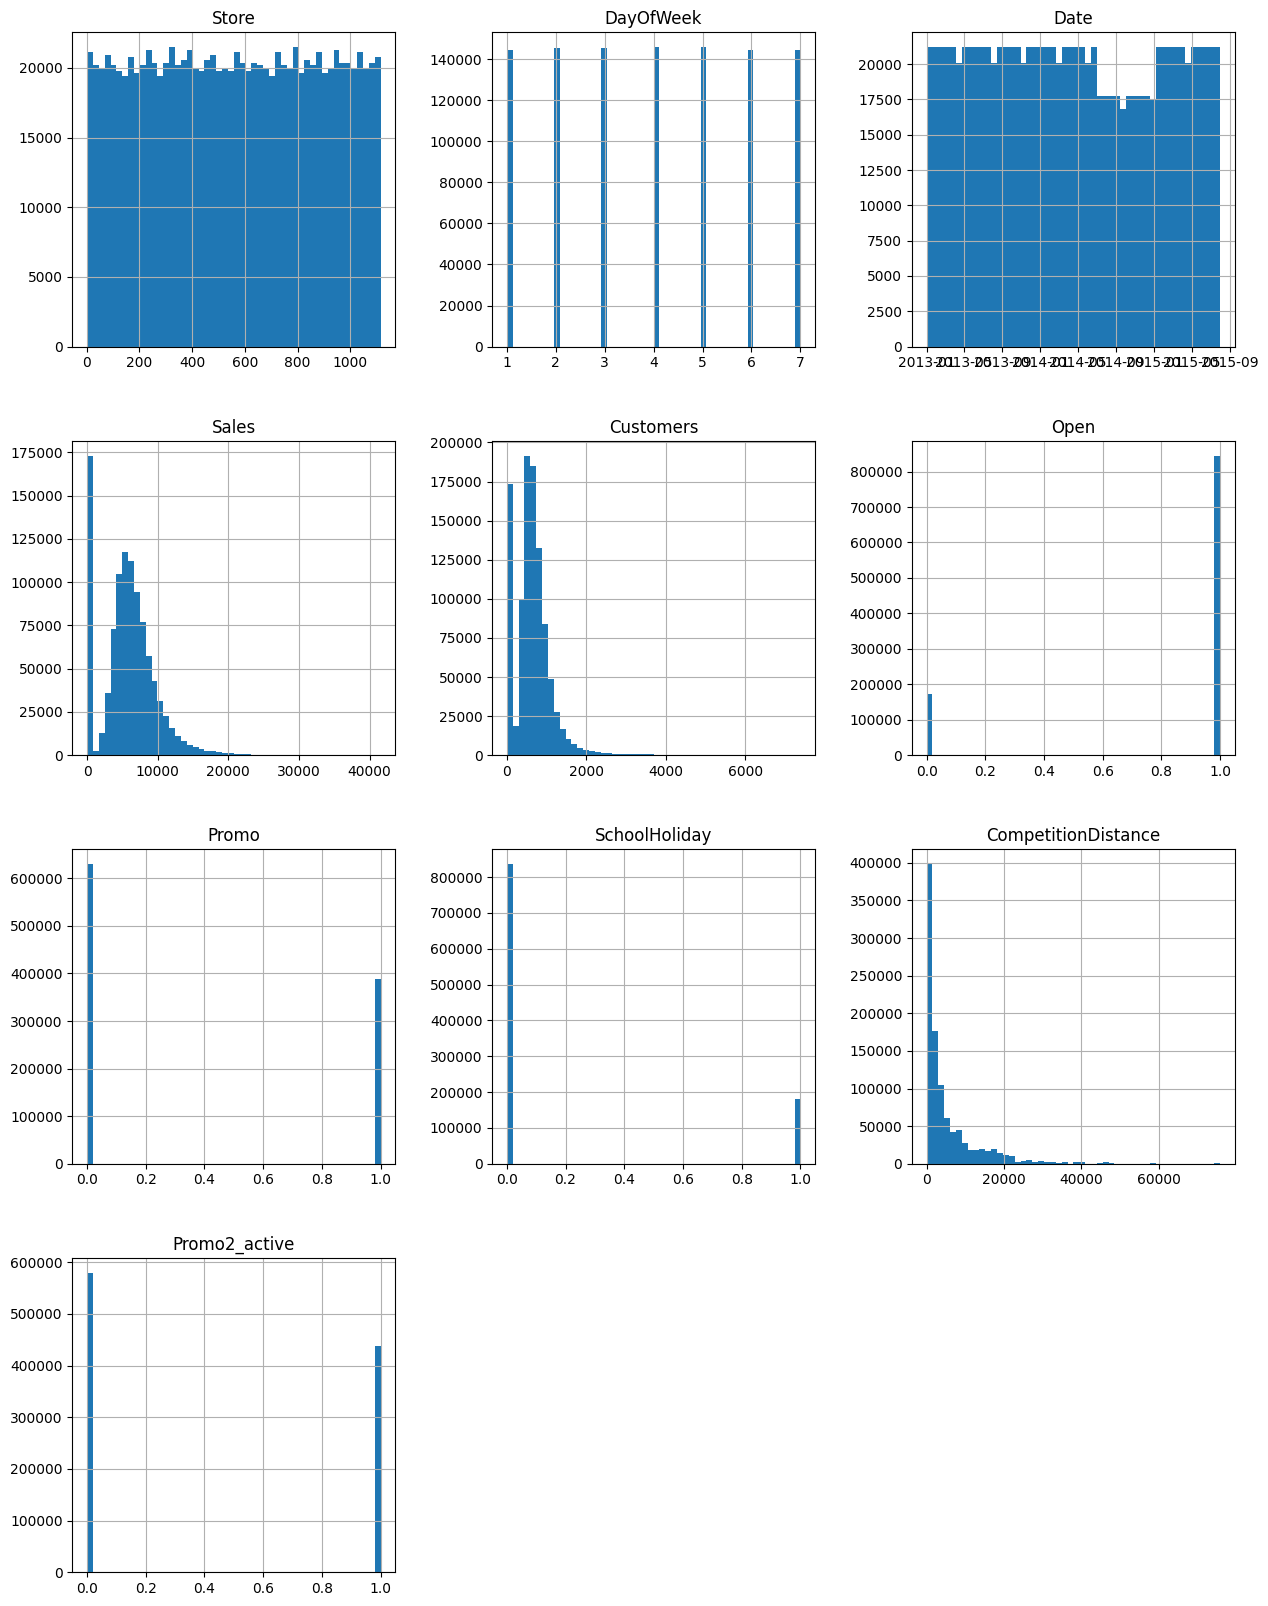

In [36]:
df.hist(bins=50,figsize=(15,20))

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 14 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   Store                1017209 non-null  int64         
 1   DayOfWeek            1017209 non-null  int64         
 2   Date                 1017209 non-null  datetime64[ns]
 3   Sales                1017209 non-null  int64         
 4   Customers            1017209 non-null  int64         
 5   Open                 1017209 non-null  int64         
 6   Promo                1017209 non-null  int64         
 7   StateHoliday         1017209 non-null  object        
 8   SchoolHoliday        1017209 non-null  int64         
 9   StoreType            1017209 non-null  object        
 10  Assortment           1017209 non-null  object        
 11  CompetitionDistance  1017209 non-null  float64       
 12  PromoInterval        1017209 non-null  object        
 1

In [38]:
for col in df.columns:
  if col in ['CompetitionDistance', 'Sales', 'Date', 'Store', 'DayOfYear', 'Customers']:
    continue
  else:
    print(f'Унікальні значення в стовпці {col} :', df[col].unique())

Унікальні значення в стовпці DayOfWeek : [2 3 4 5 6 7 1]
Унікальні значення в стовпці Open : [0 1]
Унікальні значення в стовпці Promo : [0 1]
Унікальні значення в стовпці StateHoliday : ['a' 0 'b' 'c']
Унікальні значення в стовпці SchoolHoliday : [1 0]
Унікальні значення в стовпці StoreType : ['d' 'a' 'c' 'b']
Унікальні значення в стовпці Assortment : ['c' 'a' 'b']
Унікальні значення в стовпці PromoInterval : ['Mar,Jun,Sept,Dec' 'None' 'Feb,May,Aug,Nov' 'Jan,Apr,Jul,Oct']
Унікальні значення в стовпці Promo2_active : [1 0]


#### Візуалізуємо залежність категорійних даних і продажів

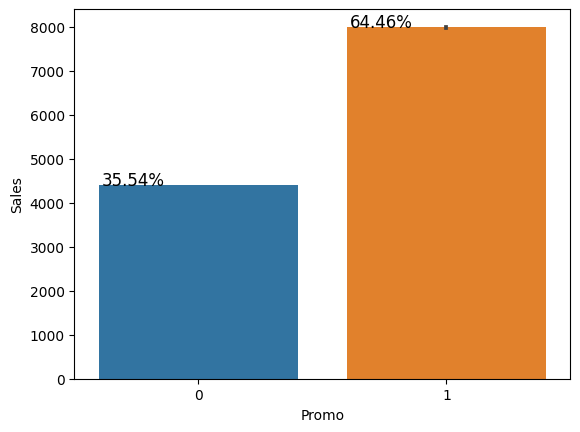

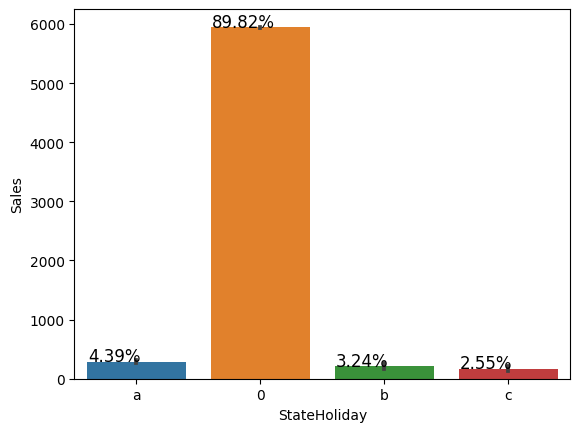

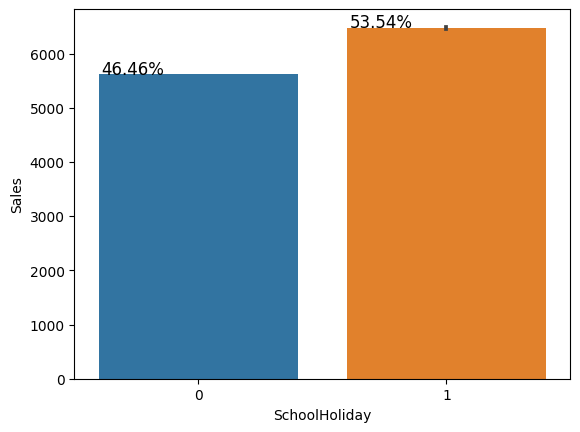

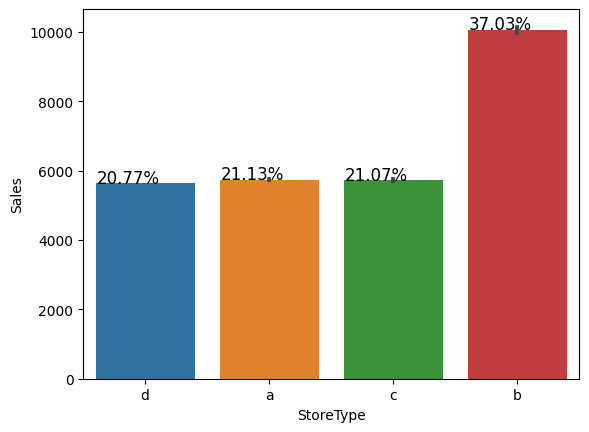

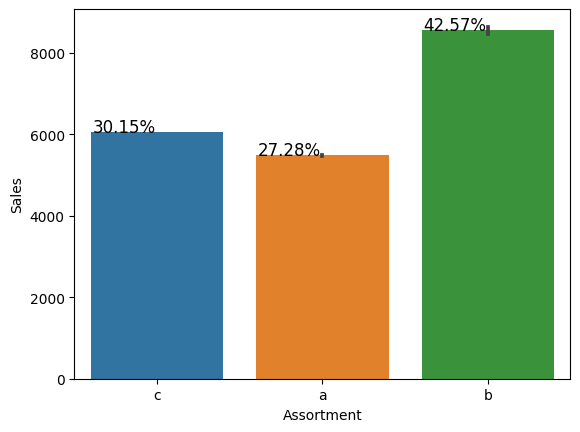

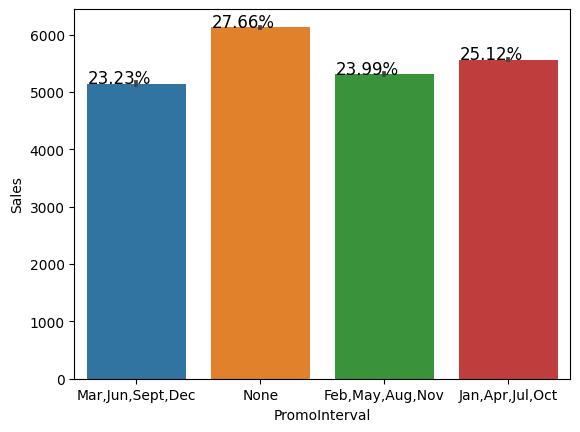

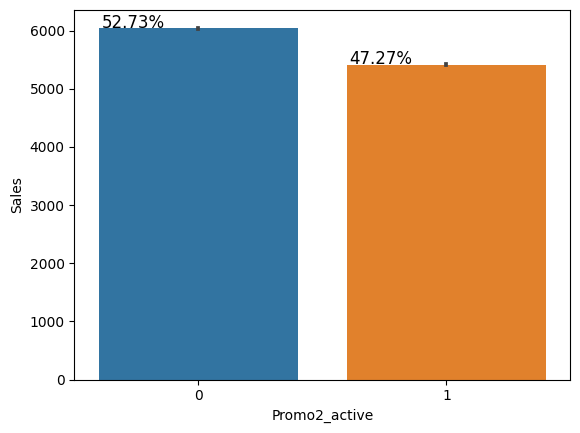

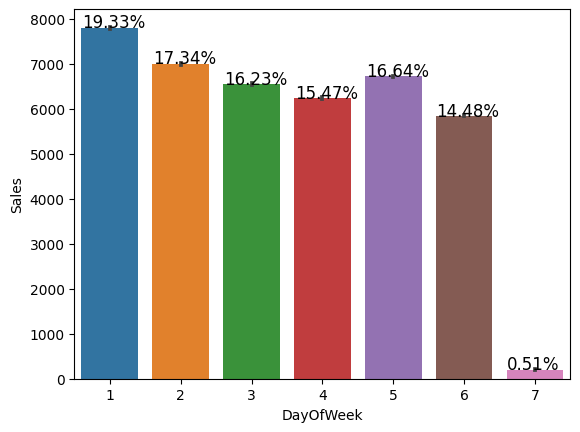

In [39]:
independent_variables = ['Promo', 'StateHoliday','SchoolHoliday','StoreType','Assortment',
                         'PromoInterval','Promo2_active', 'DayOfWeek']
for var in independent_variables:
  ax = sns.barplot(x=df[var], y=df['Sales'])
  totals = []
  for i in ax.patches:
      totals.append(i.get_height())
      total = sum(totals)
  for i in ax.patches:  
      ax.text(i.get_x() + .01, i.get_height() + 2.5, str(round((i.get_height()/total)*100, 2))+'%', fontsize=12)

  plt.show()

### Висновки:

* #### З вівторка по п'ятницю об'єм продажів коливається в середньому від 14,5% до 17,3%. В неділю продажі дуже незначні, оскільки більшість магазинів закриті в цей день. Відповідно в понеділок продажі найбільші через відкладений попит.

* #### При активному промо спостерірається дуже значне зростання об'єму продажів.

* #### При активному промо 2 спостерірається незначне зростання об'єму продажів.

* #### Під час шкільних канікул спостерігається зростання об'єму продажів.

* #### Магазини типів a, c, d показують приблизно однакові сумарні продажі, а от магазини типу b мають набагато більші об'єми продажів, хоча цих магазинів менше всього по кількості.

* #### Магазини з асортиментом типів a, c показують приблизно однакові сумарні продажі, а от магазини з асортиментом типу b мають набагато більші об'єми продажів, хоча таких магазинів менше всього по кількості.

In [40]:
# Дослідимо звязок між продажами і тим, чи був відкритий магазин
df[df.Open==0][df.Sales!=0].shape

(0, 14)

* #### Отже очевидно, що продажів у закритих магазинах немає. Тому ми можемо видалити такі рядки з наших даних для моделювання, а також видалити колонку Open. 

In [41]:
df = df[df.Open!=0]

* #### Також згідно нашої теплової карти, ми бачимо, що колонки Sales та Customers мають дуже високу залежність, тому колонку Customers ми також видаляємо з наших даних для моделювання. 

* #### Очевидно що поле Customers також можна брати для прогнозування. 

In [42]:
# Видаляємо колонки 'Open' та 'Customers'
df.drop(columns = ['Open', 'Customers'], axis=1,inplace= True)
df.head()

,Store,DayOfWeek,Date,Sales,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,PromoInterval,Promo2_active
1,1115,3,2013-01-02,3697,0,0,1,d,c,5350.0,"Mar,Jun,Sept,Dec",1
2,1115,4,2013-01-03,4297,0,0,1,d,c,5350.0,"Mar,Jun,Sept,Dec",1
3,1115,5,2013-01-04,4540,0,0,1,d,c,5350.0,"Mar,Jun,Sept,Dec",1
4,1115,6,2013-01-05,4771,0,0,1,d,c,5350.0,"Mar,Jun,Sept,Dec",1
6,1115,1,2013-01-07,6905,1,0,1,d,c,5350.0,"Mar,Jun,Sept,Dec",1


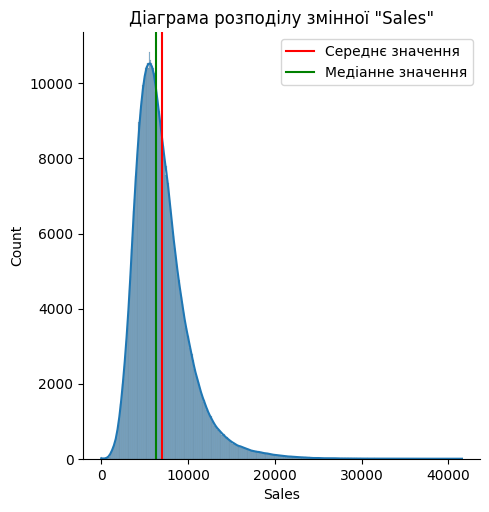

In [43]:
# Візуалізуємо значення нашої досліджуваної величини - поля Sales
sns.displot(df, x='Sales', kde=True)
plt.axvline(x=df.Sales.mean(), color='red', label='Середнє значення')
plt.axvline(x=df.Sales.median(), color='green', label='Медіанне значення')
plt.legend(loc = 'upper right')
plt.title('Діаграма розподілу змінної "Sales"');

In [44]:
# Виділяємо рік, місяць і день зі стовпця «Дата»
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['DayOfYear'] = df['Date'].dt.dayofyear

In [45]:
# Видаляємо колонки 'Date'
df.drop(columns = ['Date'], axis=1,inplace= True)

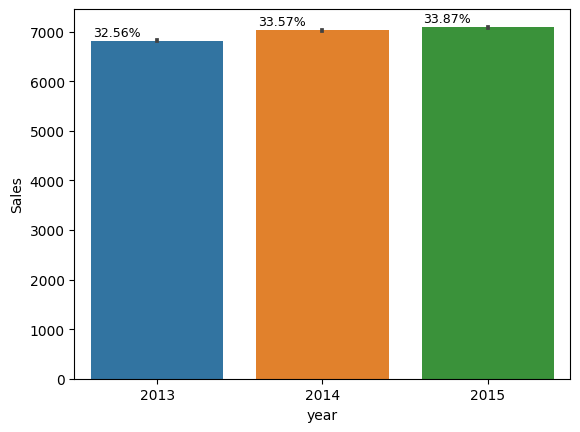

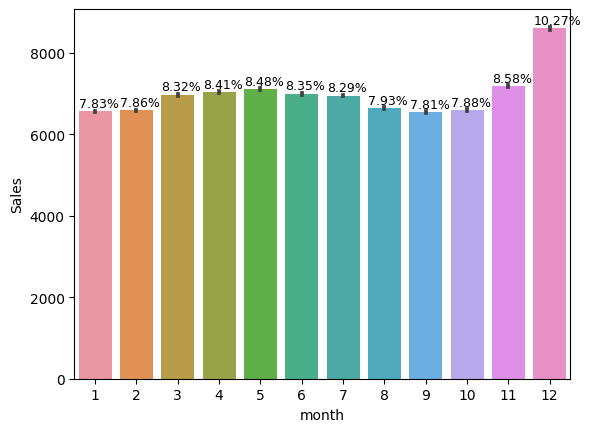

In [46]:
date_variables = ['year', 'month']
for var in date_variables:
  ax = sns.barplot(x=df[var], y=df['Sales'])
  totals = []
  for i in ax.patches:
      totals.append(i.get_height())
      total = sum(totals)
  for i in ax.patches:  
      ax.text(i.get_x() + .01, i.get_height() + 100 , str(round((i.get_height()/total)*100, 2))+'%', fontsize=9)

  plt.show()

* #### Спостерігається тенденція зростання об'єму річних продажів мережі.
* #### Об'єми продажів відповідно до місяців змінююся відповідно в межах 7,81% - 8.58% з січня по листопад. В грудні спостерігається значне зростання продажів до 10,27% через Різдво та новорічні свята.

In [47]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 1 to 1017208
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Store                844392 non-null  int64  
 1   DayOfWeek            844392 non-null  int64  
 2   Sales                844392 non-null  int64  
 3   Promo                844392 non-null  int64  
 4   StateHoliday         844392 non-null  object 
 5   SchoolHoliday        844392 non-null  int64  
 6   StoreType            844392 non-null  object 
 7   Assortment           844392 non-null  object 
 8   CompetitionDistance  844392 non-null  float64
 9   PromoInterval        844392 non-null  object 
 10  Promo2_active        844392 non-null  int32  
 11  year                 844392 non-null  int64  
 12  month                844392 non-null  int64  
 13  DayOfYear            844392 non-null  int64  
dtypes: float64(1), int32(1), int64(8), object(4)
memory usage: 125.7+ M

#### Замінюємо категорійні дані на числові в відповідних полях

In [48]:
df.Assortment.value_counts()

a    444909
c    391271
b      8212
Name: Assortment, dtype: int64

In [49]:
# Замінюємо категорійні дані на числові в полі "Assortment"
encoders_nums = {"Assortment":{"a":1,"b":2,"c":3} }
df = df.replace(encoders_nums)

In [50]:
df.Assortment.value_counts()

1    444909
3    391271
2      8212
Name: Assortment, dtype: int64

In [51]:
print(df.StateHoliday.value_counts())

0    843482
a       694
b       145
c        71
Name: StateHoliday, dtype: int64


In [52]:
# Замінюємо категорійні дані на числові в полі "StateHoliday"
encoders_nums = {"StateHoliday":{"a":1,"b":2,"c":3} }
df = df.replace(encoders_nums)

In [53]:
df.StateHoliday.value_counts()

0    843482
1       694
2       145
3        71
Name: StateHoliday, dtype: int64

In [54]:
df.StoreType.value_counts()

a    457077
d    258774
c    112978
b     15563
Name: StoreType, dtype: int64

In [55]:
# Замінюємо категорійні дані на числові в полі "StoreType"
encoders_nums = {"StoreType":{"a":1,"b":2,"c":3,"d":4 } }
df = df.replace(encoders_nums)

In [56]:
df.StoreType.value_counts()

1    457077
4    258774
3    112978
2     15563
Name: StoreType, dtype: int64

In [57]:
df.PromoInterval.value_counts()

None                423307
Jan,Apr,Jul,Oct     242411
Feb,May,Aug,Nov      98005
Mar,Jun,Sept,Dec     80669
Name: PromoInterval, dtype: int64

In [58]:
# Замінюємо категорійні дані на числові в полі "PromoInterval"
encoders_nums = {"PromoInterval":{"Jan,Apr,Jul,Oct":1,"Feb,May,Aug,Nov":2,"Mar,Jun,Sept,Dec":3,'None':4 } }
df = df.replace(encoders_nums)

In [59]:
df.PromoInterval.value_counts()

4    423307
1    242411
2     98005
3     80669
Name: PromoInterval, dtype: int64

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 1 to 1017208
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Store                844392 non-null  int64  
 1   DayOfWeek            844392 non-null  int64  
 2   Sales                844392 non-null  int64  
 3   Promo                844392 non-null  int64  
 4   StateHoliday         844392 non-null  int64  
 5   SchoolHoliday        844392 non-null  int64  
 6   StoreType            844392 non-null  int64  
 7   Assortment           844392 non-null  int64  
 8   CompetitionDistance  844392 non-null  float64
 9   PromoInterval        844392 non-null  int64  
 10  Promo2_active        844392 non-null  int32  
 11  year                 844392 non-null  int64  
 12  month                844392 non-null  int64  
 13  DayOfYear            844392 non-null  int64  
dtypes: float64(1), int32(1), int64(12)
memory usage: 125.7 MB


                                             |                                                                …


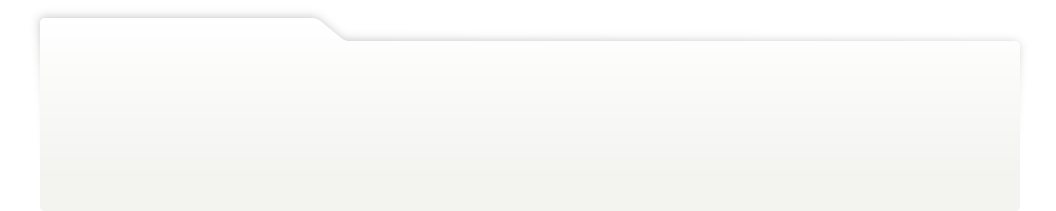
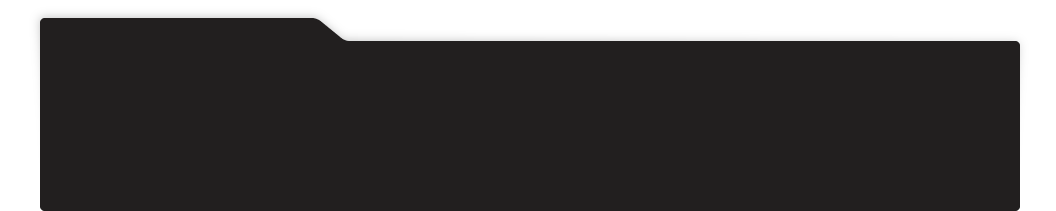
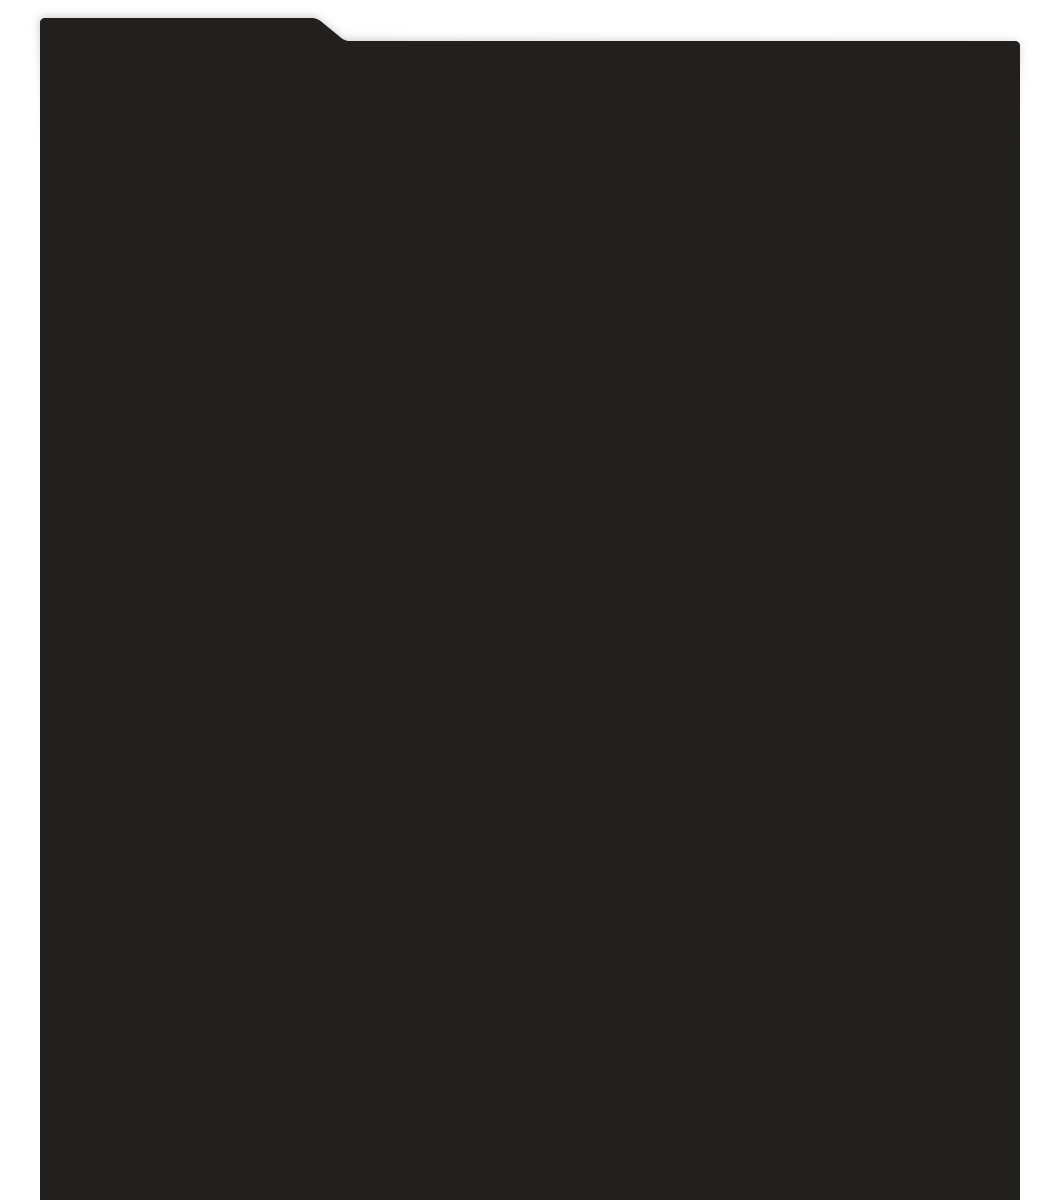
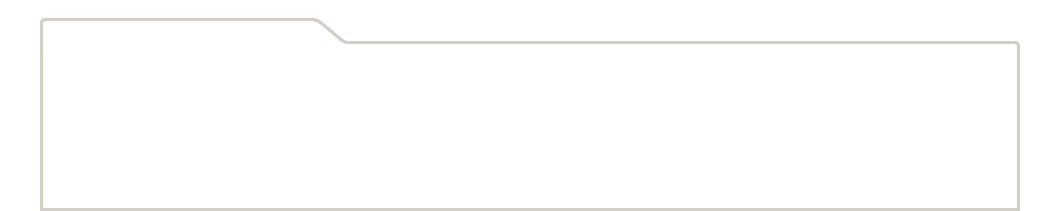
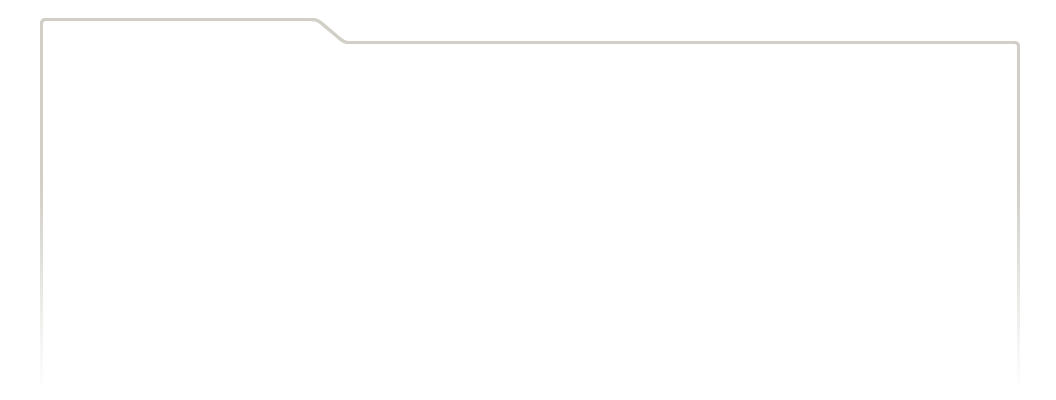
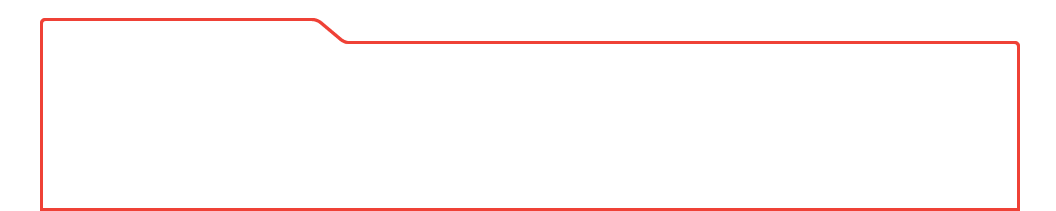
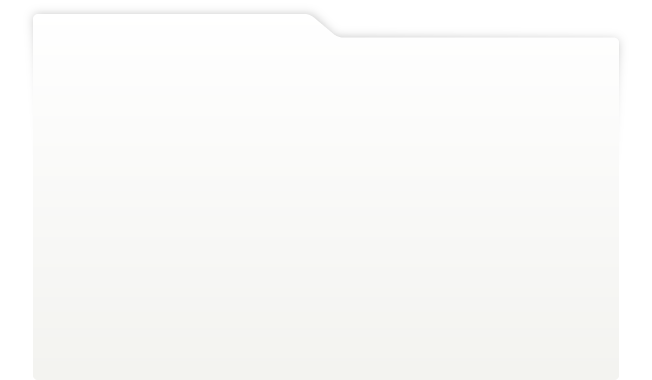
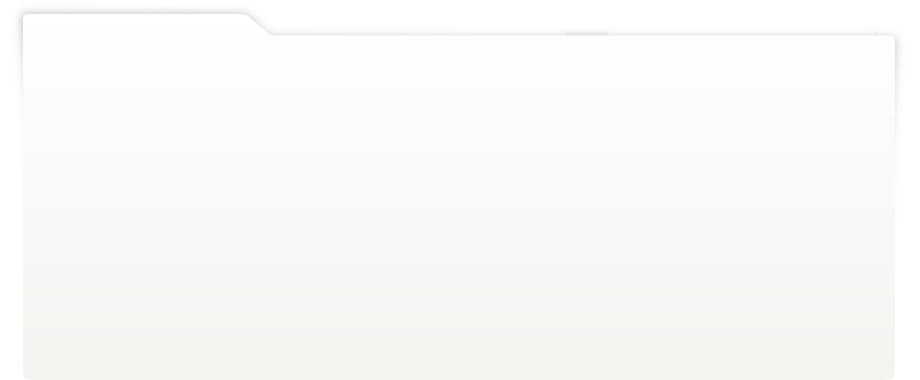
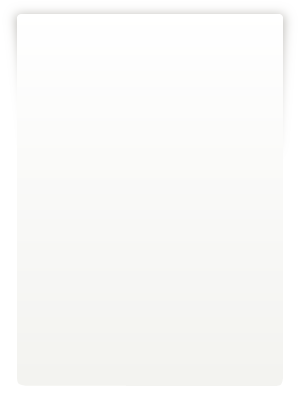
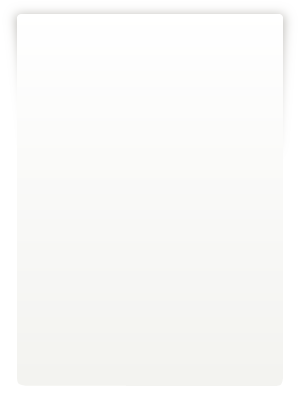
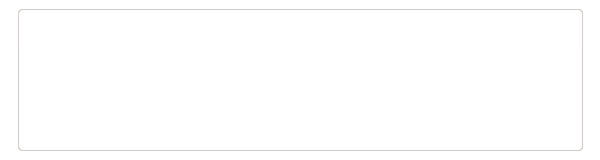
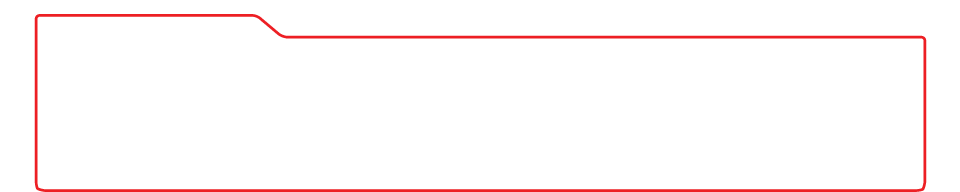
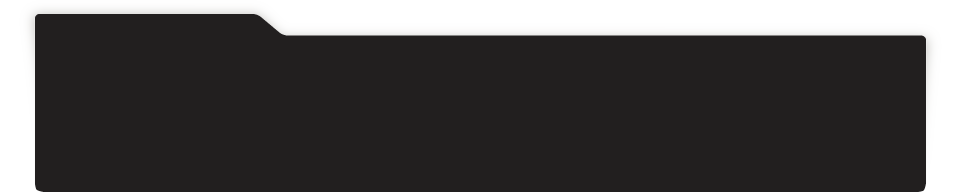
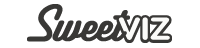
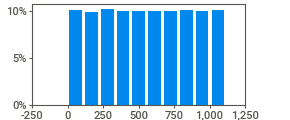
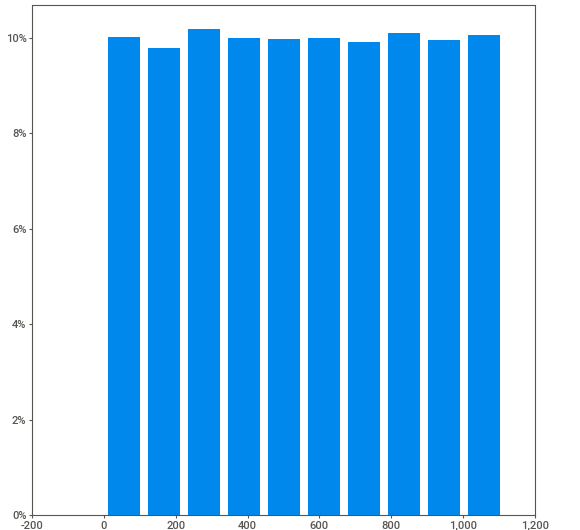
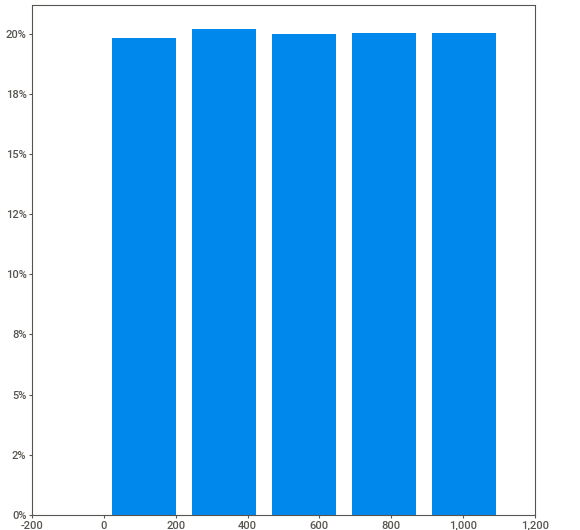
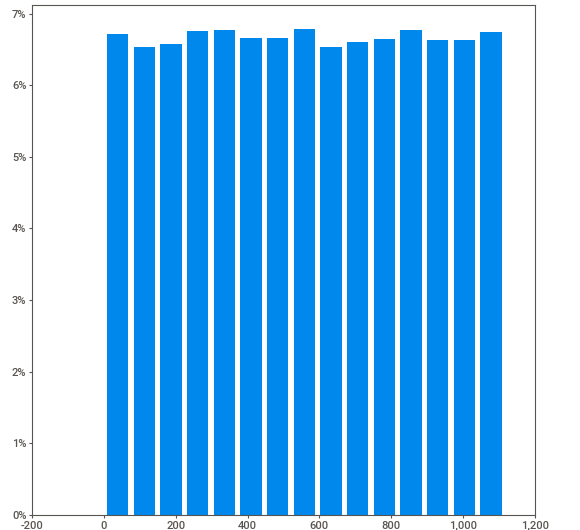
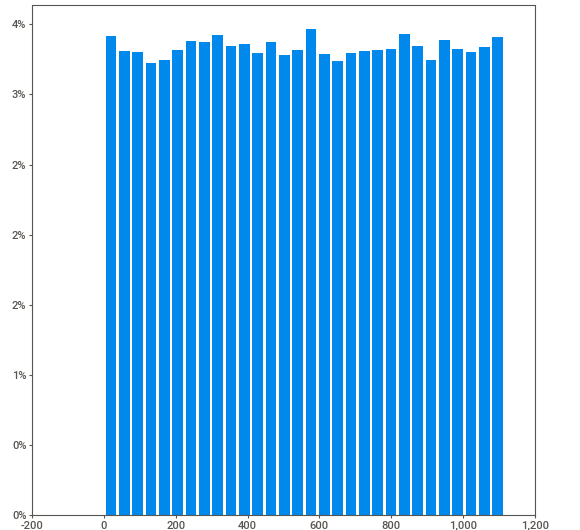
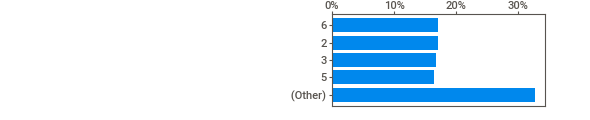
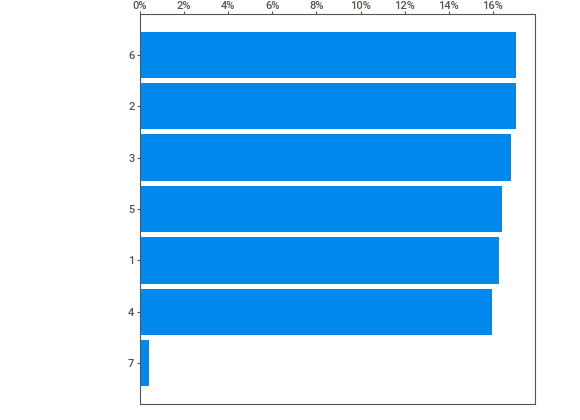
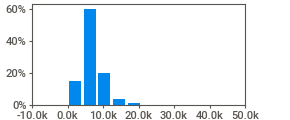
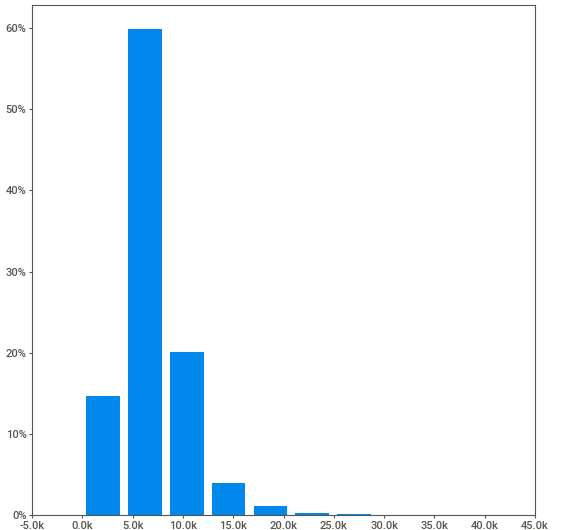
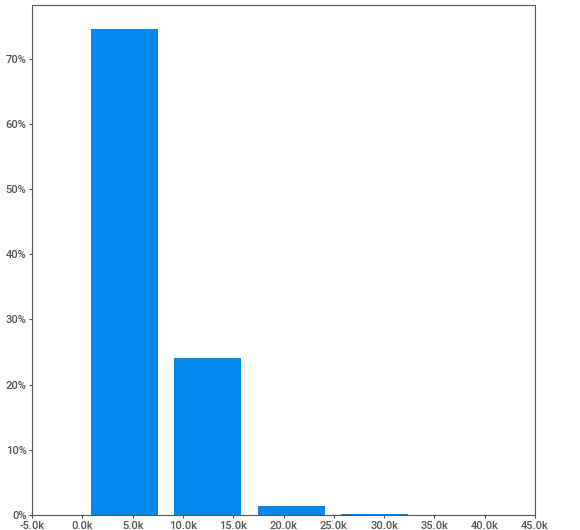
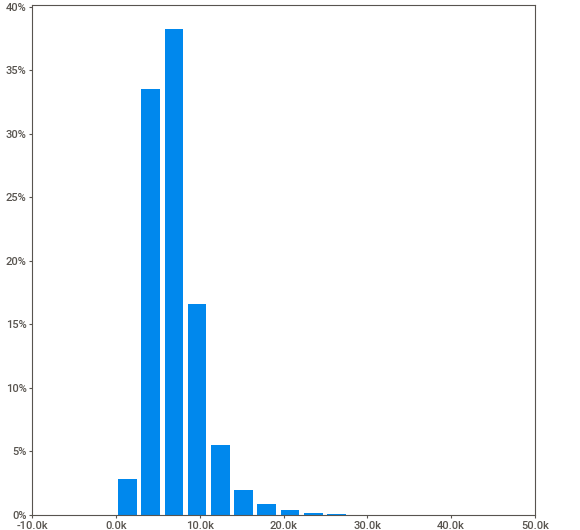
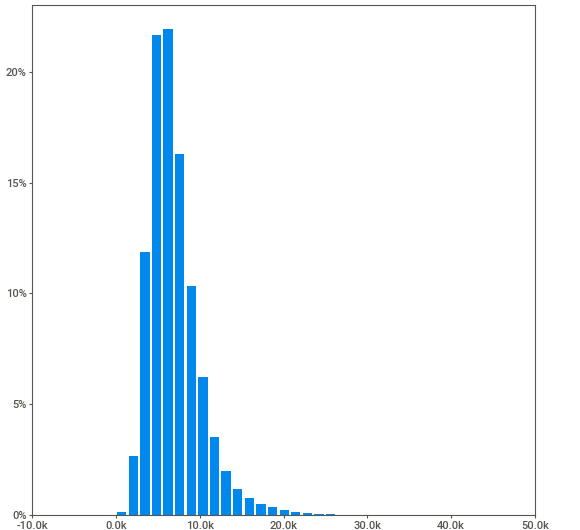
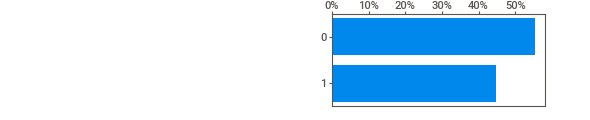
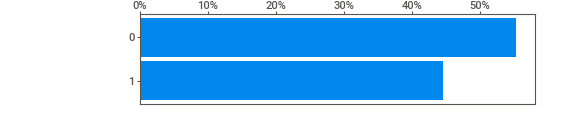
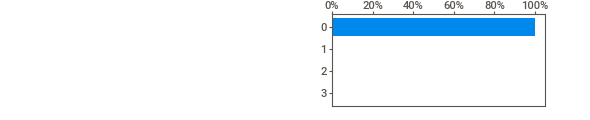
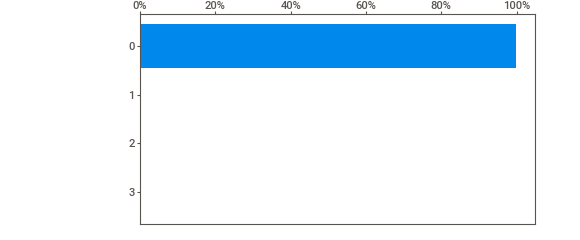
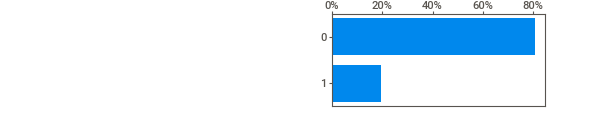
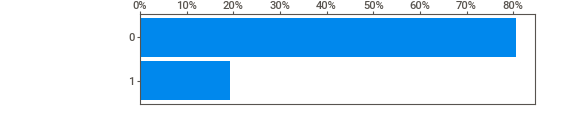
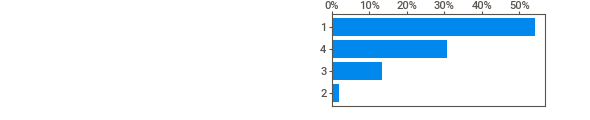
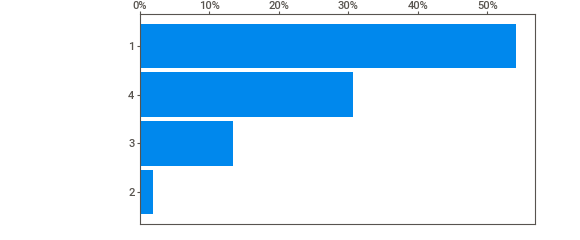
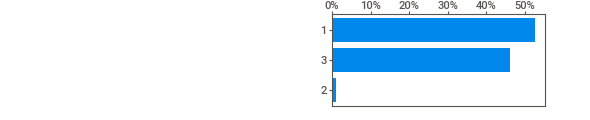
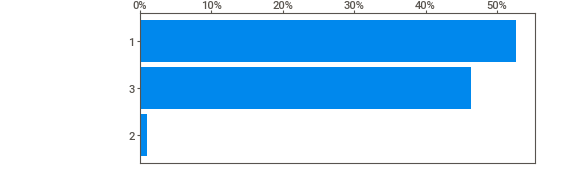
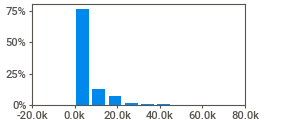
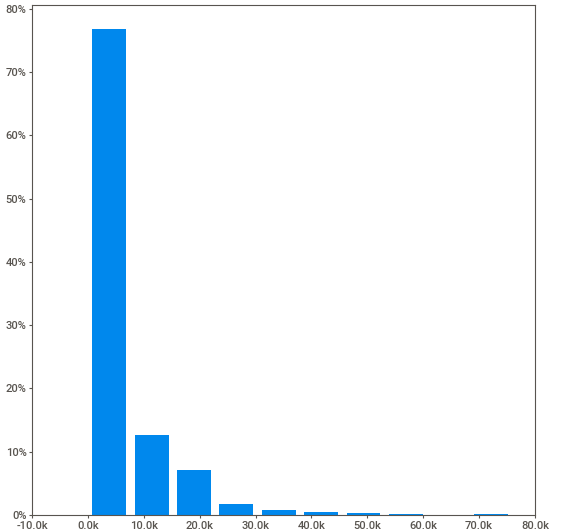
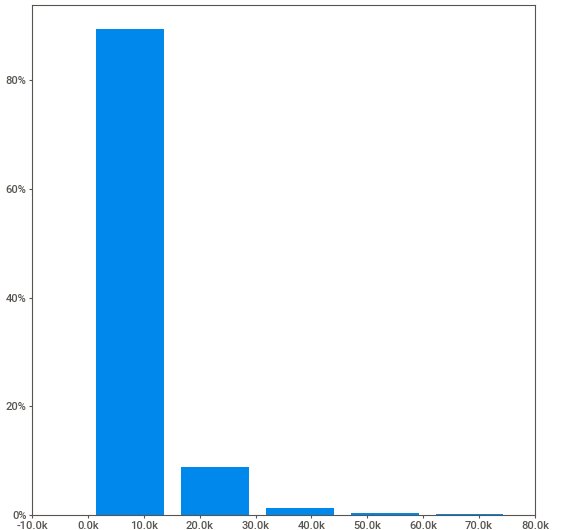
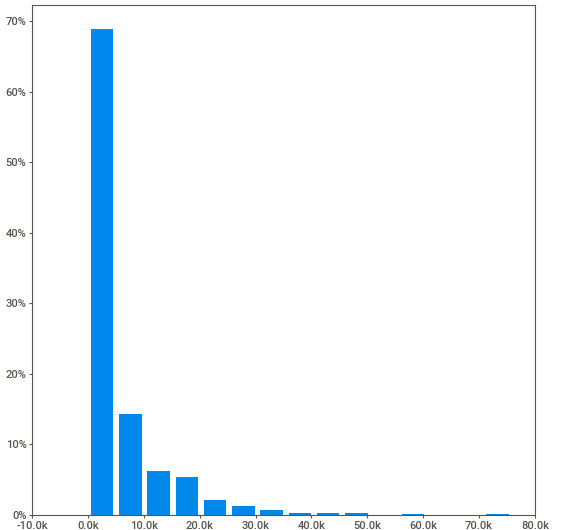
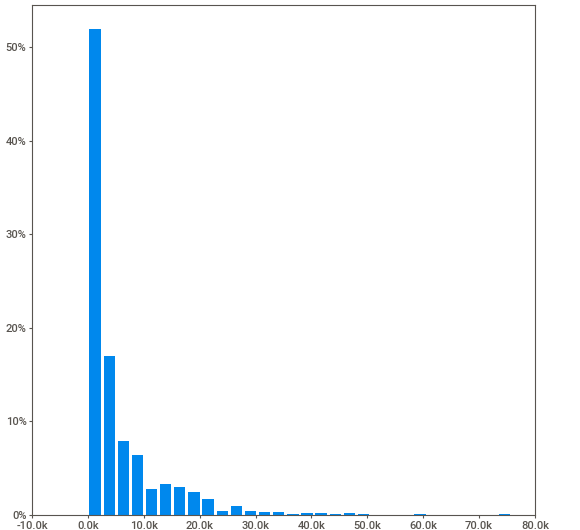
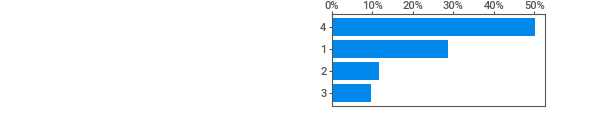
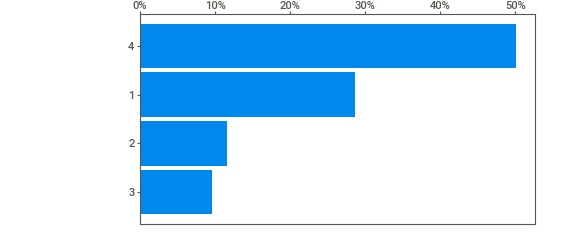
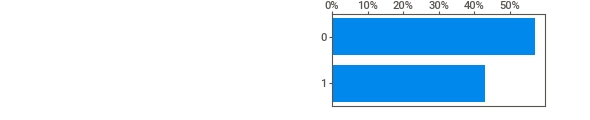
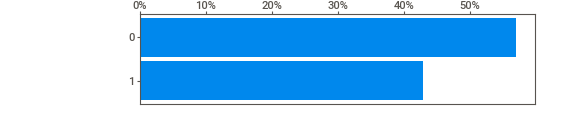
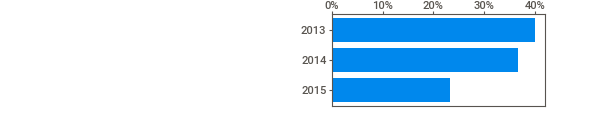
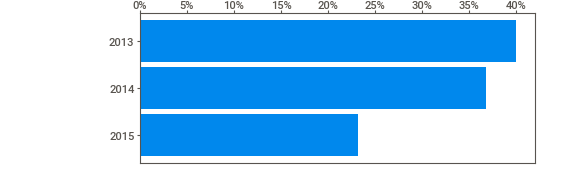
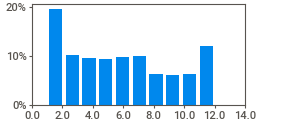
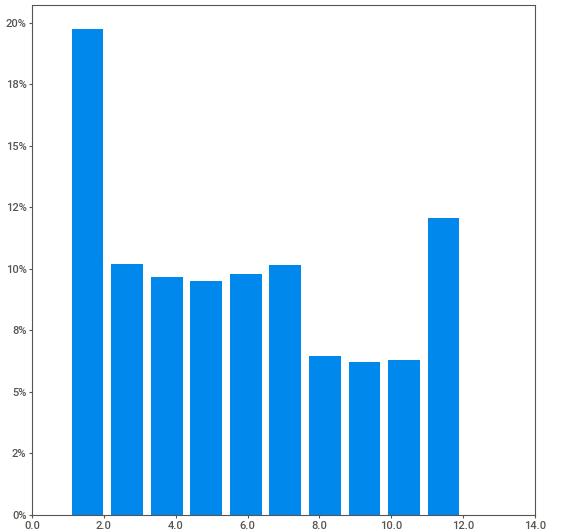
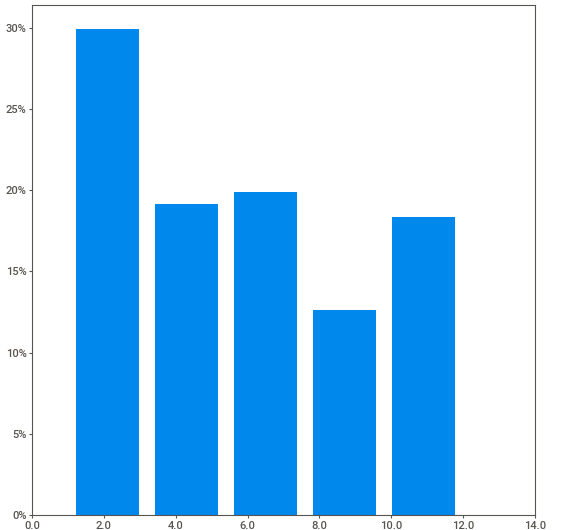
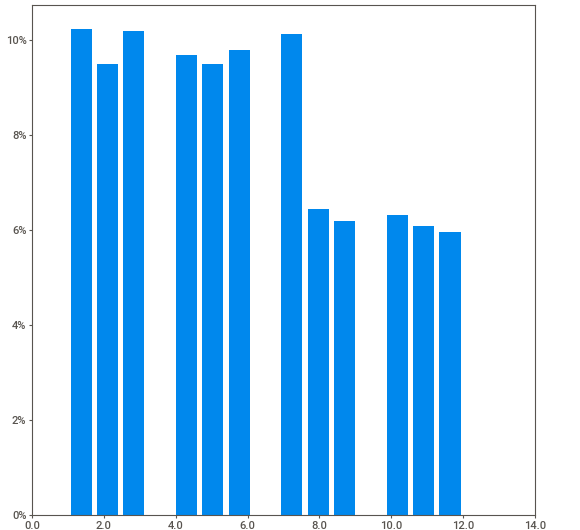
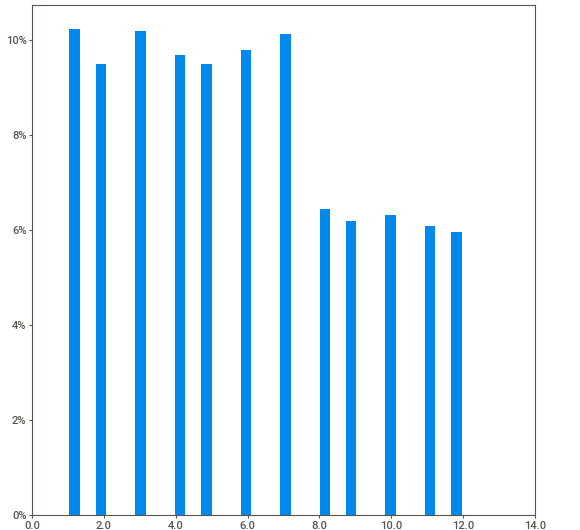
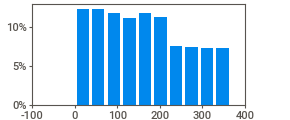
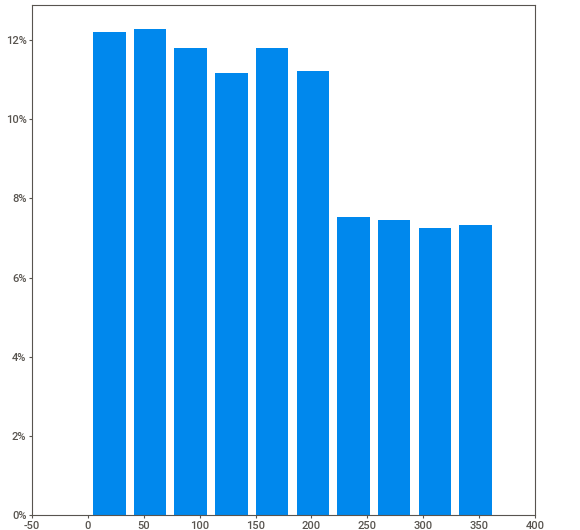
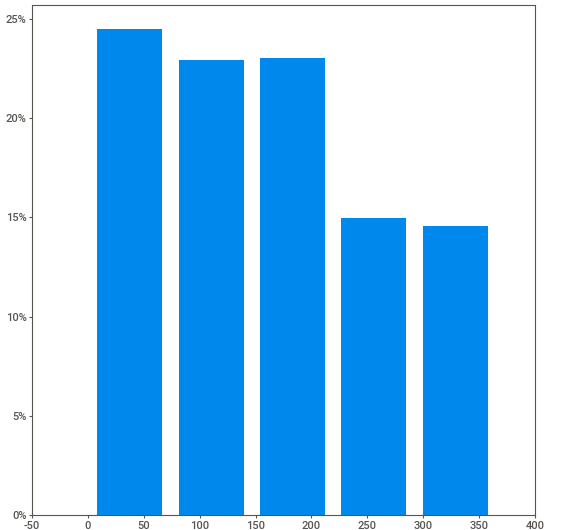
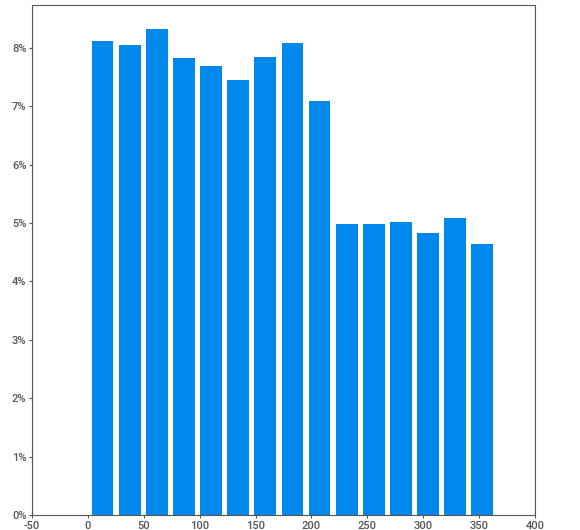
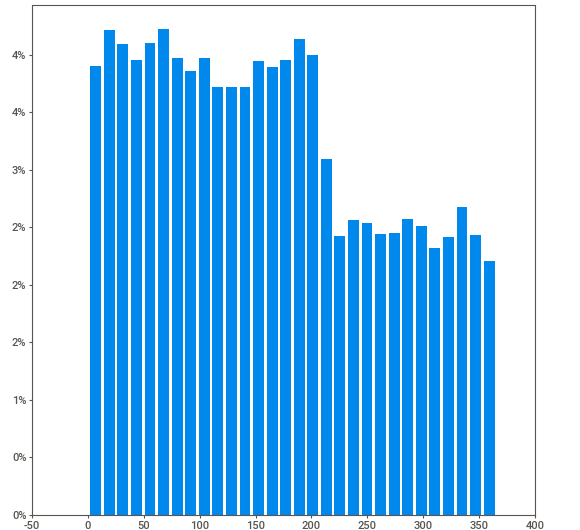
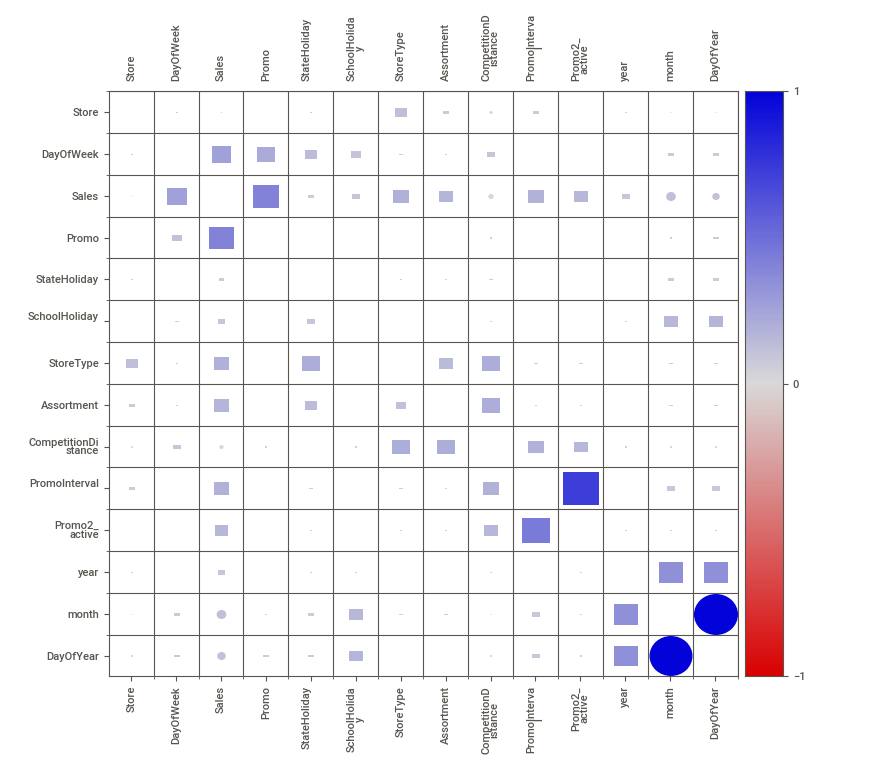
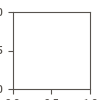

In [61]:
import sweetviz as sv
result = sv.analyze(df)
result.show_notebook()

In [62]:
# збереження фінального датасету
df.to_csv('Data/final_train_data.csv')

In [63]:
# завантаження збереженого фінального датасету
df = pd.read_csv('Data/final_train_data.csv', index_col=0)

#### Отже ми провели всі підготовчі маніпуляції з даними датасету та підготували датасет до створення моделі машинного навчання.

## `3. Побудова моделі машинного навчання`

In [62]:
# Визначаємо наші залежні та незалежні величини Х та y
y = df[['Sales']]
X = df.drop('Sales', axis=1)

In [63]:
# Розділяємо датасет на тренувальну на навчальну частину
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [64]:
# Метрики для оцінки нашої моделі
metrics = pd.DataFrame(columns=['Model','MSE','MAE','RMSE','R2 Score', 'Adjusted R2'])
metrics

,Model,MSE,MAE,RMSE,R2 Score,Adjusted R2


* #### 'MSE' означає середньоквадратичну помилку (mean squared error) і є метрикою, яка вимірює середню квадратичну відстань між прогнозованими і фактичними значеннями. Вона обчислюється як середнє значення квадратів відхилень між прогнозованими і фактичними значеннями.

* #### 'MAE' означає середню абсолютну помилку (mean absolute error) і є метрикою, яка вимірює середню абсолютну відстань між прогнозованими і фактичними значеннями. Вона обчислюється як середнє значення абсолютних відхилень між прогнозованими і фактичними значеннями.

* #### 'RMSE' означає квадратний корінь середньоквадратичної помилки (root mean squared error) і є метрикою, яка вимірює середню квадратичну відстань між прогнозованими і фактичними значеннями, але зі значенням, яке є в тих самих одиницях, що й самі дані. Вона обчислюється як корінь з середнього значення квадратів відхилень між прогнозованими і фактичними значеннями.

* #### 'R2 Score' означає коефіцієнт детермінації (coefficient of determination) і є метрикою, яка вимірює відповідність між прогнозованими і фактичними значеннями. Вона показує, яку частину змінної відповіді в моделі можна пояснити змінними пояснювальними. Значення R2 Score може бути в діапазоні від 0 до 1, де 1 означає ідеальну відповідність, а 0 - жодної відповідності.
* #### 'Adjusted R2' - враховує кількість змінних, використаних у моделі, та відображає, наскільки добре модель прогнозує дані, враховуючи рівень складності моделі. Він може бути корисним інструментом для порівняння різних моделей з різною кількістю змінних та визначенням того, яка модель має кращу здатність прогнозувати дані з урахуванням складності моделі. Він визначається як: Adjusted R2 = 1 - [(1-R2)*(n-1)/(n-k-1)], де n є кількістю спостережень у вибірці, а k є кількістю змінних, використаних у моделі.

## `Linear Regression`

In [65]:
# Тренуємо модель
Linear_reg = LinearRegression()
Linear_reg.fit(X_train,y_train)

LinearRegression()

In [66]:
# Оцінюємо точність моделі на тренувальних даних
Linear_reg.score(X_train,y_train)

0.1827132390585091

In [67]:
# Робимо прогноз на тестувальну частину
y_pred = Linear_reg.predict(X_test)

In [68]:
# Оцінюємо показники моделі

MSE  = mean_squared_error(y_test, y_pred)
print("MSE :" , MSE)

MAE=mean_absolute_error(y_test, y_pred)
print("MAE :" ,MAE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score(y_test, y_pred)
print("R2 :" ,r2)

Adjusted_R2 = 1-(1-r2_score(y_test, y_pred))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Adjusted R2 : ",Adjusted_R2)

MSE : 7856396.105590719
MAE : 2035.5195424888932
RMSE : 2802.9263468009144
R2 : 0.1824125668005101
Adjusted R2 :  0.1823496251806861


In [69]:
# Добавляємо показники моделі в список для порівняння
LR = {'Model':'Linear Regression', 'MSE': MSE, 'MAE':MAE, 'RMSE':RMSE, 'R2 Score': r2,'Adjusted R2': Adjusted_R2}
metrics = metrics.append(LR, ignore_index=True)
metrics

,Model,MSE,MAE,RMSE,R2 Score,Adjusted R2
0,Linear Regression,7.856396e+06,2035.519542,2802.926347,0.182413,0.18235


## `Lasso Regression`

In [70]:
# Створюємо модель
lasso = Lasso(alpha=0.005,max_iter=3000)

In [71]:
# Тренуємо модель
lasso.fit(X_train,y_train)

Lasso(alpha=0.005, max_iter=3000)

In [72]:
# Оцінюємо точність моделі на тренувальних даних
lasso.score(X_train,y_train)

0.18271323786400695

In [73]:
# Робимо прогноз на тестувальну частину
y_pred_lasso = lasso.predict(X_test)

In [74]:
# Оцінюємо показники моделі

MSE  = mean_squared_error(y_test, y_pred_lasso)
print("MSE :" , MSE)

MAE=mean_absolute_error(y_test, y_pred_lasso)
print("MAE :" ,MAE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score(y_test, y_pred_lasso)
print("R2 :" ,r2)

Adjusted_R2 = 1-(1-r2_score(y_test, y_pred_lasso))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Adjusted R2 : ", Adjusted_R2)

MSE : 7856396.521611397
MAE : 2035.5193516517622
RMSE : 2802.9264210127594
R2 : 0.18241252350670534
Adjusted R2 :  0.18234958188354833


In [75]:
# Добавляємо показники моделі в список для порівняння
LaR = {'Model':'Lasso Regression', 'MSE': MSE, 'MAE':MAE, 'RMSE':RMSE, 'R2 Score': r2,'Adjusted R2': Adjusted_R2}
metrics = metrics.append(LaR, ignore_index=True)
metrics

,Model,MSE,MAE,RMSE,R2 Score,Adjusted R2
0,Linear Regression,7.856396e+06,2035.519542,2802.926347,0.182413,0.18235
1,Lasso Regression,7.856397e+06,2035.519352,2802.926421,0.182413,0.18235


## `Ridge Regression`

In [76]:
# Створюємо модель
ridge = Ridge(alpha=0.1)

In [77]:
# Тренуємо модель
ridge.fit(X_train,y_train)

Ridge(alpha=0.1)

In [78]:
# Оцінюємо точність моделі на тренувальних даних
ridge.score(X_train, y_train)

0.18271323905694037

In [79]:
# Робимо прогноз на тестувальну частину
y_pred_ridge = ridge.predict(X_test)

In [80]:
# Оцінюємо показники моделі

MSE  = mean_squared_error(y_test, y_pred_ridge)
print("MSE :" , MSE)

MAE=mean_absolute_error(y_test, y_pred_ridge)
print("MAE :" ,MAE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score(y_test, y_pred_ridge)
print("R2 :" ,r2)

Adjusted_R2 = 1-(1-r2_score(y_test, y_pred_ridge))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Adjusted R2 : ", Adjusted_R2)

MSE : 7856396.108197413
MAE : 2035.5195422400693
RMSE : 2802.9263472659095
R2 : 0.18241256652924054
Adjusted R2 :  0.18234962490939555


In [81]:
# Добавляємо показники моделі в список для порівняння
RR = {'Model':'Ridge Regression', 'MSE': MSE, 'MAE':MAE, 'RMSE':RMSE, 'R2 Score': r2, 'Adjusted R2': Adjusted_R2}
metrics = metrics.append(RR,ignore_index=True)
metrics

,Model,MSE,MAE,RMSE,R2 Score,Adjusted R2
0,Linear Regression,7.856396e+06,2035.519542,2802.926347,0.182413,0.18235
1,Lasso Regression,7.856397e+06,2035.519352,2802.926421,0.182413,0.18235
2,Ridge Regression,7.856396e+06,2035.519542,2802.926347,0.182413,0.18235


## `XG Boost Regressor`

In [82]:
# Створюємо модель
xgbr = XGBRegressor()

In [83]:
# Тренуємо модель
xgbr.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [84]:
# Оцінюємо точність моделі на тренувальних даних
xgbr.score(X_train, y_train)

0.8461849398610114

In [85]:
# Робимо прогноз на тестувальну частину
y_pred_xgbr = xgbr.predict(X_test)

In [86]:
# Оцінюємо показники моделі

MSE  = mean_squared_error(y_test, y_pred_xgbr)
print("MSE :" , MSE)

MAE=mean_absolute_error(y_test, y_pred_xgbr)
print("MAE :" ,MAE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score(y_test, y_pred_xgbr)
print("R2 :" ,r2)

Adjusted_R2 = 1-(1-r2_score(y_test, y_pred_xgbr))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Adjusted R2 : ", Adjusted_R2)

MSE : 1482685.2803423682
MAE : 869.0402358387971
RMSE : 1217.655649328811
R2 : 0.8457021723058048
Adjusted R2 :  0.8456902937533515


In [87]:
# Добавляємо показники моделі в список для порівняння
XG = {'Model':'XGBoost Regression', 'MSE': MSE, 'MAE':MAE, 'RMSE':RMSE, 'R2 Score': r2, 'Adjusted R2': Adjusted_R2}
metrics = metrics.append(XG,ignore_index=True)
metrics

,Model,MSE,MAE,RMSE,R2 Score,Adjusted R2
0,Linear Regression,7.856396e+06,2035.519542,2802.926347,0.182413,0.18235
1,Lasso Regression,7.856397e+06,2035.519352,2802.926421,0.182413,0.18235
2,Ridge Regression,7.856396e+06,2035.519542,2802.926347,0.182413,0.18235
3,XGBoost Regression,1.482685e+06,869.040236,1217.655649,0.845702,0.84569


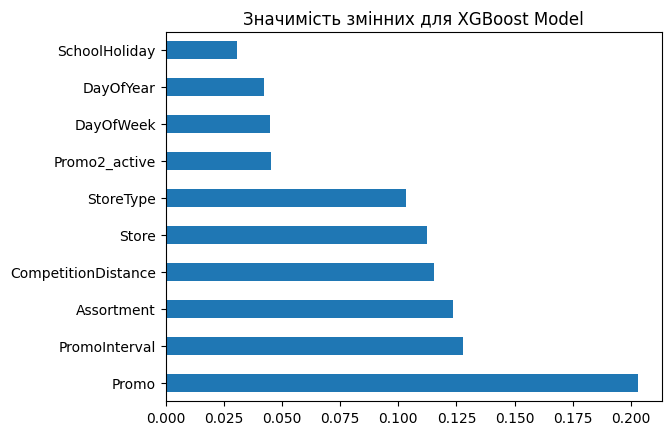

In [88]:
# Візуалізуємо значимість показників в нашій моделі
important_features = pd.Series(xgbr.feature_importances_, index=X.columns)
important_features.nlargest(10).plot(kind='barh')
plt.title('Значимість змінних для XGBoost Model')
plt.show()

## `XG Boost Regressor з кросс валідацією`

In [89]:
#Cross Validation with Grid Search CV
xgbr = XGBRegressor()
parameters = {}
xgbr_regressor = GridSearchCV(xgbr, parameters, scoring='neg_mean_squared_error', cv=5)
xgbr_regressor.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid={}, scoring='neg_mean_squared_error')

In [90]:
# Оцінюємо точність моделі на тренувальних даних
xgbr_regressor.score(X_train, y_train)

-1483216.3064384186

In [91]:
# Робимо прогноз на тестувальну частину
y_pred_xgbr1 = xgbr_regressor.predict(X_test)

In [92]:
# Оцінюємо показники моделі

MSE  = mean_squared_error(y_test, y_pred_xgbr1)
print("MSE :" , MSE)

MAE=mean_absolute_error(y_test, y_pred_xgbr1)
print("MAE :" ,MAE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score(y_test, y_pred_xgbr1)
print("R2 :" ,r2)

Adjusted_R2 = 1-(1-r2_score(y_test, y_pred_xgbr1))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Adjusted R2 : ", Adjusted_R2)

MSE : 1482685.2803423682
MAE : 869.0402358387971
RMSE : 1217.655649328811
R2 : 0.8457021723058048
Adjusted R2 :  0.8456902937533515


In [93]:
# Добавляємо показники моделі в список для порівняння
XG1 = {'Model':'XGBoost Regression (with CV)', 'MSE': MSE, 'MAE':MAE, 'RMSE':RMSE, 'R2 Score': r2, 'Adjusted R2': Adjusted_R2}
metrics = metrics.append(XG1,ignore_index=True)
metrics

,Model,MSE,MAE,RMSE,R2 Score,Adjusted R2
0,Linear Regression,7.856396e+06,2035.519542,2802.926347,0.182413,0.18235
1,Lasso Regression,7.856397e+06,2035.519352,2802.926421,0.182413,0.18235
2,Ridge Regression,7.856396e+06,2035.519542,2802.926347,0.182413,0.18235
3,XGBoost Regression,1.482685e+06,869.040236,1217.655649,0.845702,0.84569
4,XGBoost Regression (with CV),1.482685e+06,869.040236,1217.655649,0.845702,0.84569


## `XG Boost Regressor з кросс валідацією та гіперпараметрами`

In [94]:
xgbr = XGBRegressor()
parameters = {
             'max_depth': [15],
             'n_estimators': [120],
             'subsample': [0.7]
             }
xgbr_regressor = GridSearchCV(xgbr, parameters, scoring='neg_mean_squared_error', cv=5, n_jobs = -1)
xgbr_regressor.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=-1,
             param_grid={'max_depth': [15], 'n_estimators': [120],
                         'subsample': [0.7]},
             scoring='neg_mean_squared_error')

In [95]:
# Оцінюємо точність моделі на тренувальних даних
xgbr_regressor.score(X_train, y_train)

-95719.45224897623

In [96]:
# Робимо прогноз на тестувальну частину
y_pred_xgbr2 = xgbr_regressor.predict(X_test)

In [97]:
# Оцінюємо показники моделі

MSE  = mean_squared_error(y_test, y_pred_xgbr2)
print("MSE :" , MSE)

MAE=mean_absolute_error(y_test, y_pred_xgbr2)
print("MAE :" ,MAE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score(y_test, y_pred_xgbr2)
print("R2 :" ,r2)

Adjusted_R2 = 1-(1-r2_score(y_test, y_pred_xgbr2))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Adjusted R2 : ", Adjusted_R2)

MSE : 548156.45066276
MAE : 502.08694544792235
RMSE : 740.3758847117861
R2 : 0.942955291527347
Adjusted R2 :  0.9429508999647962


In [98]:
# Добавляємо показники моделі в список для порівняння
XG2 = {'Model':'XGBoost Regression (with CV and HP)', 'MSE': MSE, 'MAE':MAE, 'RMSE':RMSE, 'R2 Score': r2, 'Adjusted R2': Adjusted_R2}
metrics = metrics.append(XG2,ignore_index=True)
metrics

,Model,MSE,MAE,RMSE,R2 Score,Adjusted R2
0,Linear Regression,7.856396e+06,2035.519542,2802.926347,0.182413,0.182350
1,Lasso Regression,7.856397e+06,2035.519352,2802.926421,0.182413,0.182350
2,Ridge Regression,7.856396e+06,2035.519542,2802.926347,0.182413,0.182350
3,XGBoost Regression,1.482685e+06,869.040236,1217.655649,0.845702,0.845690
4,XGBoost Regression (with CV),1.482685e+06,869.040236,1217.655649,0.845702,0.845690
5,XGBoost Regression (with CV and HP),5.481565e+05,502.086945,740.375885,0.942955,0.942951


## `Random Forest Regressor`

In [99]:
# Створюємо модель
rf_regressor = RandomForestRegressor()

In [100]:
# Тренуємо модель
rf_regressor.fit(X_train,y_train)

RandomForestRegressor()

In [101]:
# Оцінюємо точність моделі на тренувальних даних
rf_regressor.score(X_train,y_train)

0.986734087217892

In [102]:
# Робимо прогноз на тестувальну частину
y_pred_rf = rf_regressor.predict(X_test)

In [103]:
# Оцінюємо показники моделі

MSE  = mean_squared_error(y_test, y_pred_rf)
print("MSE :" , MSE)

MAE=mean_absolute_error(y_test, y_pred_rf)
print("MAE :" ,MAE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score(y_test, y_pred_rf)
print("R2 :" ,r2)

Adjusted_R2 = 1-(1-r2_score(y_test, y_pred_rf))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Adjusted R2 : ", Adjusted_R2)

MSE : 896195.1669772597
MAE : 615.2258675146112
RMSE : 946.6758510584601
R2 : 0.9067361298530615
Adjusted R2 :  0.9067289499737976


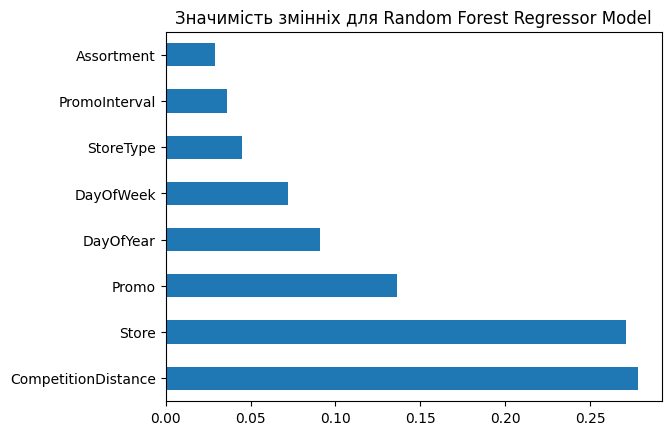

In [104]:
# Візуалізуємо значимість змінніх в нашій моделі
important_features = pd.Series(rf_regressor.feature_importances_, index=X.columns)
important_features.nlargest(8).plot(kind='barh')
plt.title('Значимість змінніх для Random Forest Regressor Model')
plt.show()

In [105]:
# Добавляємо показники моделі в список для порівняння
RF = {'Model':'Random Forest Regression ', 'MSE': MSE, 'MAE':MAE, 'RMSE':RMSE, 'R2 Score': r2, 'Adjusted R2': Adjusted_R2}
metrics = metrics.append(RF,ignore_index=True)
metrics

,Model,MSE,MAE,RMSE,R2 Score,Adjusted R2
0,Linear Regression,7.856396e+06,2035.519542,2802.926347,0.182413,0.182350
1,Lasso Regression,7.856397e+06,2035.519352,2802.926421,0.182413,0.182350
2,Ridge Regression,7.856396e+06,2035.519542,2802.926347,0.182413,0.182350
3,XGBoost Regression,1.482685e+06,869.040236,1217.655649,0.845702,0.845690
4,XGBoost Regression (with CV),1.482685e+06,869.040236,1217.655649,0.845702,0.845690
5,XGBoost Regression (with CV and HP),5.481565e+05,502.086945,740.375885,0.942955,0.942951
6,Random Forest Regression,8.961952e+05,615.225868,946.675851,0.906736,0.906729


## `Random Forest Regressor з кросс валідацією`

In [106]:
#Cross Validation with Grid Search CV

rf_regressor = RandomForestRegressor()
parameters = {}
rf_regressor = GridSearchCV(rf_regressor,parameters, scoring='neg_mean_squared_error', cv=5, n_jobs = -1)
rf_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1, param_grid={},
             scoring='neg_mean_squared_error')

In [107]:
rf_regressor.score

<bound method BaseSearchCV.score of GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1, param_grid={},
             scoring='neg_mean_squared_error')>

In [108]:
# Робимо прогноз на тестувальну частину
y_pred_rf_cv = rf_regressor.predict(X_test)

In [109]:
# Оцінюємо показники моделі

MSE  = mean_squared_error(y_test, y_pred_rf_cv)
print("MSE :" , MSE)

MAE=mean_absolute_error(y_test, y_pred_rf_cv)
print("MAE :" ,MAE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score(y_test, y_pred_rf_cv)
print("R2 :" ,r2)

Adjusted_R2 = 1-(1-r2_score(y_test, y_pred_rf_cv))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Adjusted R2 : ", Adjusted_R2)

MSE : 894080.8004179928
MAE : 614.5968009047896
RMSE : 945.558459545465
R2 : 0.9069561645235135
Adjusted R2 :  0.9069490015835248


In [110]:
# Добавляємо показники моделі в список для порівняння
RF1 = {'Model':'Random Forest Regression (with CV)', 'MSE': MSE, 'MAE':MAE, 'RMSE':RMSE, 'R2 Score': r2, 'Adjusted R2': Adjusted_R2}
metrics = metrics.append(RF1,ignore_index=True)
metrics

,Model,MSE,MAE,RMSE,R2 Score,Adjusted R2
0,Linear Regression,7.856396e+06,2035.519542,2802.926347,0.182413,0.182350
1,Lasso Regression,7.856397e+06,2035.519352,2802.926421,0.182413,0.182350
2,Ridge Regression,7.856396e+06,2035.519542,2802.926347,0.182413,0.182350
3,XGBoost Regression,1.482685e+06,869.040236,1217.655649,0.845702,0.845690
4,XGBoost Regression (with CV),1.482685e+06,869.040236,1217.655649,0.845702,0.845690
5,XGBoost Regression (with CV and HP),5.481565e+05,502.086945,740.375885,0.942955,0.942951
6,Random Forest Regression,8.961952e+05,615.225868,946.675851,0.906736,0.906729
7,Random Forest Regression (with CV),8.940808e+05,614.596801,945.558460,0.906956,0.906949


## `Random Forest Regressor з кросс валідацією та гіперпараметрами`

In [111]:
#Cross Validation with Grid Search CV and HP
#parameters = {
#    'max_depth': [80, 100],
#    'max_features': [2, 3],
#    'min_samples_leaf': [3, 5],
#    'min_samples_split': [8, 12],
#    'n_estimators': [10, 100, 1000]
#    'random_state': [0, 42]
#}


rf_regressor = RandomForestRegressor()
parameters = {
    'bootstrap': [True],
    'max_depth': [80],
    'n_estimators': [100],
    'max_features': [3],
    'min_samples_split': [8],
    'min_samples_leaf': [3, 5],
    'random_state': [42]
}

rf_regressor = GridSearchCV(rf_regressor,parameters, scoring='neg_mean_squared_error', cv=5, n_jobs = -1, verbose = 2)
rf_regressor.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [80],
                         'max_features': [3], 'min_samples_leaf': [3, 5],
                         'min_samples_split': [8], 'n_estimators': [100],
                         'random_state': [42]},
             scoring='neg_mean_squared_error', verbose=2)

In [112]:
rf_regressor.score

<bound method BaseSearchCV.score of GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [80],
                         'max_features': [3], 'min_samples_leaf': [3, 5],
                         'min_samples_split': [8], 'n_estimators': [100],
                         'random_state': [42]},
             scoring='neg_mean_squared_error', verbose=2)>

In [113]:
print("Визначено найкращі показники гіперпараметрів:" ,rf_regressor.best_params_)
print("The negative mean squared error is: ", rf_regressor.best_score_)

Визначено найкращі показники гіперпараметрів: {'bootstrap': True, 'max_depth': 80, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100, 'random_state': 42}
The negative mean squared error is:  -2054799.8961444206


In [114]:
# Робимо прогноз на тестувальну частину
y_pred_rf_cvhp = rf_regressor.predict(X_test)

In [115]:
# Оцінюємо показники моделі

MSE  = mean_squared_error(y_test, y_pred_rf_cvhp)
print("MSE :" , MSE)

MAE=mean_absolute_error(y_test, y_pred_rf_cvhp)
print("MAE :" ,MAE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score(y_test, y_pred_rf_cvhp)
print("R2 :" ,r2)

Adjusted_R2 = 1-(1-r2_score(y_test, y_pred_rf_cvhp))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Adjusted R2 : ", Adjusted_R2)

MSE : 1901039.319964816
MAE : 951.818418994033
RMSE : 1378.781824642614
R2 : 0.8021655429370088
Adjusted R2 :  0.802150312735713


In [116]:
#Cross Validation with Grid Search CV and HP

rf_regressor = RandomForestRegressor()
parameters = {
    'max_depth': [80],
    'n_estimators': [100],
    'random_state': [0, 42]
}

rf_regressor = GridSearchCV(rf_regressor,parameters, scoring='neg_mean_squared_error', cv=5, n_jobs = -1)
rf_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [80], 'n_estimators': [100],
                         'random_state': [0, 42]},
             scoring='neg_mean_squared_error')

In [117]:
rf_regressor.score

<bound method BaseSearchCV.score of GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [80], 'n_estimators': [100],
                         'random_state': [0, 42]},
             scoring='neg_mean_squared_error')>

In [118]:
print("Визначено найкращі показники гіперпараметрів:" ,rf_regressor.best_params_)
print("The negative mean squared error is: ", rf_regressor.best_score_)

Визначено найкращі показники гіперпараметрів: {'max_depth': 80, 'n_estimators': 100, 'random_state': 42}
The negative mean squared error is:  -967935.1806440059


In [119]:
# Робимо прогноз на тестувальну частину
y_pred_rf_cvhp = rf_regressor.predict(X_test)

In [120]:
# Оцінюємо показники моделі

MSE  = mean_squared_error(y_test, y_pred_rf_cvhp)
print("MSE :" , MSE)

MAE=mean_absolute_error(y_test, y_pred_rf_cvhp)
print("MAE :" ,MAE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score(y_test, y_pred_rf_cvhp)
print("R2 :" ,r2)

Adjusted_R2 = 1-(1-r2_score(y_test, y_pred_rf_cvhp))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Adjusted R2 : ", Adjusted_R2)

MSE : 900581.556668841
MAE : 615.9619833134966
RMSE : 948.9897558292403
R2 : 0.9062796537486553
Adjusted R2 :  0.9062724387277731


In [121]:
# Добавляємо показники моделі в список для порівняння
RF2 = {'Model':'Random Forest Regression (with CV and HP)', 'MSE': MSE, 'MAE':MAE, 'RMSE':RMSE, 'R2 Score': r2, 'Adjusted R2': Adjusted_R2}
metrics = metrics.append(RF2,ignore_index=True)
metrics

,Model,MSE,MAE,RMSE,R2 Score,Adjusted R2
0,Linear Regression,7.856396e+06,2035.519542,2802.926347,0.182413,0.182350
1,Lasso Regression,7.856397e+06,2035.519352,2802.926421,0.182413,0.182350
2,Ridge Regression,7.856396e+06,2035.519542,2802.926347,0.182413,0.182350
3,XGBoost Regression,1.482685e+06,869.040236,1217.655649,0.845702,0.845690
4,XGBoost Regression (with CV),1.482685e+06,869.040236,1217.655649,0.845702,0.845690
5,XGBoost Regression (with CV and HP),5.481565e+05,502.086945,740.375885,0.942955,0.942951
6,Random Forest Regression,8.961952e+05,615.225868,946.675851,0.906736,0.906729
7,Random Forest Regression (with CV),8.940808e+05,614.596801,945.558460,0.906956,0.906949
8,Random Forest Regression (with CV and HP),9.005816e+05,615.961983,948.989756,0.906280,0.906272


## `Cat Boost Regressor`

In [122]:
# Створюємо модель та тренуємо її
cat_r = CatBoostRegressor()

cat_r.fit(X_train, y_train, 
          eval_set=(X_test, y_test),
          verbose=200, plot=False)

Learning rate set to 0.141628
0:	learn: 3005.6790634	test: 3001.0786227	best: 3001.0786227 (0)	total: 216ms	remaining: 3m 36s
200:	learn: 1835.2017140	test: 1830.6846156	best: 1830.6846156 (200)	total: 11.3s	remaining: 44.9s
400:	learn: 1494.9459704	test: 1488.1512217	best: 1488.1512217 (400)	total: 22.6s	remaining: 33.7s
600:	learn: 1298.7193930	test: 1291.6337938	best: 1291.6337938 (600)	total: 34s	remaining: 22.6s
800:	learn: 1187.6949420	test: 1180.9579582	best: 1180.9579582 (800)	total: 45.3s	remaining: 11.3s
999:	learn: 1109.4805978	test: 1104.0037281	best: 1104.0037281 (999)	total: 57.2s	remaining: 0us

bestTest = 1104.003728
bestIteration = 999



In [123]:
# Робимо прогноз на тестувальну частину
y_pred_cat = cat_r.predict(X_test)

In [124]:
# Оцінюємо показники моделі

MSE  = mean_squared_error(y_test, y_pred_cat)
print("MSE :" , MSE)

MAE=mean_absolute_error(y_test, y_pred_cat)
print("MAE :" ,MAE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score(y_test, y_pred_cat)
print("R2 :" ,r2)

Adjusted_R2 = 1-(1-r2_score(y_test, y_pred_cat))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Adjusted R2 : ", Adjusted_R2)

MSE : 1218824.231693128
MAE : 782.142051464191
RMSE : 1104.0037281155928
R2 : 0.8731612610008035
Adjusted R2 :  0.8731514963745814


In [125]:
# Візуалізуємо значимість змінніх в нашій моделі
cat_r.get_feature_importance(prettified=True, type='FeatureImportance')

,Feature Id,Importances
0,CompetitionDistance,28.944962
1,Store,27.480032
2,Promo,9.016855
3,StoreType,8.381116
4,PromoInterval,7.270651
5,Assortment,6.384992
6,DayOfYear,4.828780
7,DayOfWeek,4.467328
8,Promo2_active,1.492803
9,year,0.805882


In [126]:
# Добавляємо показники моделі в список для порівняння
CB1 = {'Model':'Cat Boost Regressor', 'MSE': MSE, 'MAE':MAE, 'RMSE':RMSE, 'R2 Score': r2, 'Adjusted R2': Adjusted_R2}
metrics = metrics.append(CB1,ignore_index=True)
metrics

,Model,MSE,MAE,RMSE,R2 Score,Adjusted R2
0,Linear Regression,7.856396e+06,2035.519542,2802.926347,0.182413,0.182350
1,Lasso Regression,7.856397e+06,2035.519352,2802.926421,0.182413,0.182350
2,Ridge Regression,7.856396e+06,2035.519542,2802.926347,0.182413,0.182350
3,XGBoost Regression,1.482685e+06,869.040236,1217.655649,0.845702,0.845690
4,XGBoost Regression (with CV),1.482685e+06,869.040236,1217.655649,0.845702,0.845690
5,XGBoost Regression (with CV and HP),5.481565e+05,502.086945,740.375885,0.942955,0.942951
6,Random Forest Regression,8.961952e+05,615.225868,946.675851,0.906736,0.906729
7,Random Forest Regression (with CV),8.940808e+05,614.596801,945.558460,0.906956,0.906949
8,Random Forest Regression (with CV and HP),9.005816e+05,615.961983,948.989756,0.906280,0.906272
9,Cat Boost Regressor,1.218824e+06,782.142051,1104.003728,0.873161,0.873151


## `Cat Boost Regressor з гіперпараметрами`

In [127]:
# Створюємо модель та тренуємо її
cat_rh = CatBoostRegressor(iterations=3000, thread_count=-1)

cat_rh.fit(X_train, y_train, 
          eval_set=(X_test, y_test),
          verbose=200, plot=False)

Learning rate set to 0.072461
0:	learn: 3052.8392458	test: 3047.8370152	best: 3047.8370152 (0)	total: 55.8ms	remaining: 2m 47s
200:	learn: 2128.4792222	test: 2124.6484296	best: 2124.6484296 (200)	total: 11s	remaining: 2m 32s
400:	learn: 1834.6202788	test: 1828.6632866	best: 1828.6632866 (400)	total: 22s	remaining: 2m 22s
600:	learn: 1635.8391381	test: 1629.4111402	best: 1629.4111402 (600)	total: 33.5s	remaining: 2m 13s
800:	learn: 1493.5346086	test: 1486.7888014	best: 1486.7888014 (800)	total: 44.6s	remaining: 2m 2s
1000:	learn: 1388.7873061	test: 1381.1889425	best: 1381.1889425 (1000)	total: 55.7s	remaining: 1m 51s
1200:	learn: 1308.8238333	test: 1301.0395129	best: 1301.0395129 (1200)	total: 1m 6s	remaining: 1m 40s
1400:	learn: 1242.9038007	test: 1235.4503287	best: 1235.4503287 (1400)	total: 1m 18s	remaining: 1m 29s
1600:	learn: 1190.2888140	test: 1182.8061038	best: 1182.8061038 (1600)	total: 1m 29s	remaining: 1m 18s
1800:	learn: 1148.8166390	test: 1141.7099752	best: 1141.7099752 (180

In [128]:
# Робимо прогноз на тестувальну частину
y_pred_cath = cat_rh.predict(X_test)

In [129]:
# Оцінюємо показники моделі

MSE  = mean_squared_error(y_test, y_pred_cath)
print("MSE :" , MSE)

MAE=mean_absolute_error(y_test, y_pred_cath)
print("MAE :" ,MAE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score(y_test, y_pred_cath)
print("R2 :" ,r2)

Adjusted_R2 = 1-(1-r2_score(y_test, y_pred_cath))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Adjusted R2 : ", Adjusted_R2)

MSE : 973623.420690534
MAE : 692.2964568458804
RMSE : 986.7235786635151
R2 : 0.8986784445785746
Adjusted R2 :  0.8986706443818466


In [130]:
# Добавляємо показники моделі в список для порівняння
CB2 = {'Model':'Cat Boost Regressor with HP', 'MSE': MSE, 'MAE':MAE, 'RMSE':RMSE, 'R2 Score': r2, 'Adjusted R2': Adjusted_R2}
metrics = metrics.append(CB2,ignore_index=True)
metrics

,Model,MSE,MAE,RMSE,R2 Score,Adjusted R2
0,Linear Regression,7.856396e+06,2035.519542,2802.926347,0.182413,0.182350
1,Lasso Regression,7.856397e+06,2035.519352,2802.926421,0.182413,0.182350
2,Ridge Regression,7.856396e+06,2035.519542,2802.926347,0.182413,0.182350
3,XGBoost Regression,1.482685e+06,869.040236,1217.655649,0.845702,0.845690
4,XGBoost Regression (with CV),1.482685e+06,869.040236,1217.655649,0.845702,0.845690
5,XGBoost Regression (with CV and HP),5.481565e+05,502.086945,740.375885,0.942955,0.942951
6,Random Forest Regression,8.961952e+05,615.225868,946.675851,0.906736,0.906729
7,Random Forest Regression (with CV),8.940808e+05,614.596801,945.558460,0.906956,0.906949
8,Random Forest Regression (with CV and HP),9.005816e+05,615.961983,948.989756,0.906280,0.906272
9,Cat Boost Regressor,1.218824e+06,782.142051,1104.003728,0.873161,0.873151


## `LightGBM`

In [131]:
# Створюємо модель та тренуємо її
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'metric': 'mae'
}

lgb_r = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 verbose_eval=20)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017929 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 810
[LightGBM] [Info] Number of data points in the train set: 675513, number of used features: 13
[LightGBM] [Info] Start training from score 6956.624022
[20]	valid_0's l1: 1837.28
[40]	valid_0's l1: 1664.91
[60]	valid_0's l1: 1555.3
[80]	valid_0's l1: 1451.77
[100]	valid_0's l1: 1367.59


In [132]:
# Робимо прогноз на тестувальну частину
y_pred_lgb = lgb_r.predict(X_test)

In [133]:
# Оцінюємо показники моделі

MSE  = mean_squared_error(y_test, y_pred_lgb)
print("MSE :" , MSE)

MAE=mean_absolute_error(y_test, y_pred_lgb)
print("MAE :" ,MAE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score(y_test, y_pred_lgb)
print("R2 :" ,r2)

Adjusted_R2 = 1-(1-r2_score(y_test, y_pred_lgb))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Adjusted R2 : ", Adjusted_R2)

MSE : 3356154.8230958455
MAE : 1367.5882801065784
RMSE : 1831.981119743281
R2 : 0.6507368047185925
Adjusted R2 :  0.650709916840473


In [134]:
# Візуалізуємо значимість змінніх в нашій моделі
df_feature_importance = (
    pd.DataFrame({
        'feature': lgb_r.feature_name(),
        'importance': lgb_r.feature_importance(),
    })
    .sort_values('importance', ascending=False)
)

df_feature_importance

,feature,importance
0,Store,914
7,CompetitionDistance,875
12,DayOfYear,354
1,DayOfWeek,166
6,Assortment,165
5,StoreType,164
8,PromoInterval,159
10,year,63
2,Promo,60
9,Promo2_active,41


In [135]:
# Добавляємо показники моделі в список для порівняння
LGB1 = {'Model':'LightGBM', 'MSE': MSE, 'MAE':MAE, 'RMSE':RMSE, 'R2 Score': r2, 'Adjusted R2': Adjusted_R2}
metrics = metrics.append(LGB1,ignore_index=True)
metrics

,Model,MSE,MAE,RMSE,R2 Score,Adjusted R2
0,Linear Regression,7.856396e+06,2035.519542,2802.926347,0.182413,0.182350
1,Lasso Regression,7.856397e+06,2035.519352,2802.926421,0.182413,0.182350
2,Ridge Regression,7.856396e+06,2035.519542,2802.926347,0.182413,0.182350
3,XGBoost Regression,1.482685e+06,869.040236,1217.655649,0.845702,0.845690
4,XGBoost Regression (with CV),1.482685e+06,869.040236,1217.655649,0.845702,0.845690
5,XGBoost Regression (with CV and HP),5.481565e+05,502.086945,740.375885,0.942955,0.942951
6,Random Forest Regression,8.961952e+05,615.225868,946.675851,0.906736,0.906729
7,Random Forest Regression (with CV),8.940808e+05,614.596801,945.558460,0.906956,0.906949
8,Random Forest Regression (with CV and HP),9.005816e+05,615.961983,948.989756,0.906280,0.906272
9,Cat Boost Regressor,1.218824e+06,782.142051,1104.003728,0.873161,0.873151


## `LightGBM з гіперпараметрами`

In [136]:
# Створюємо модель та тренуємо її
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'metric': 'mae',
    'num_boost_round':1000,
    'early_stopping_rounds':30,
    'seed': 42,
    'verbose': -1
}

lgb_rh = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 verbose_eval=100)

Training until validation scores don't improve for 30 rounds
[100]	valid_0's l1: 1365.3
[200]	valid_0's l1: 1062.51
[300]	valid_0's l1: 913.448
[400]	valid_0's l1: 821.352
[500]	valid_0's l1: 763.69
[600]	valid_0's l1: 722.374
[700]	valid_0's l1: 687.548
[800]	valid_0's l1: 664.526
[900]	valid_0's l1: 646.031
[1000]	valid_0's l1: 629.845
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 629.845


In [137]:
# Робимо прогноз на тестувальну частину
y_pred_lgbh = lgb_rh.predict(X_test)

In [138]:
# Оцінюємо показники моделі

MSE  = mean_squared_error(y_test, y_pred_lgbh)
print("MSE :" , MSE)

MAE=mean_absolute_error(y_test, y_pred_lgbh)
print("MAE :" ,MAE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score(y_test, y_pred_lgbh)
print("R2 :" ,r2)

Adjusted_R2 = 1-(1-r2_score(y_test, y_pred_lgbh))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Adjusted R2 : ", Adjusted_R2)

MSE : 800583.9897762334
MAE : 629.8453028552506
RMSE : 894.7535916531621
R2 : 0.9166860478437471
Adjusted R2 :  0.9166796339546758


In [139]:
# Візуалізуємо значимість змінніх в нашій моделі
df_feature_importance = (
    pd.DataFrame({
        'feature': lgb_rh.feature_name(),
        'importance': lgb_rh.feature_importance(),
    })
    .sort_values('importance', ascending=False)
)

df_feature_importance

,feature,importance
0,Store,7612
7,CompetitionDistance,7210
1,DayOfWeek,3344
12,DayOfYear,3249
2,Promo,1697
5,StoreType,1649
8,PromoInterval,1510
6,Assortment,1224
10,year,1172
9,Promo2_active,576


In [140]:
# Добавляємо показники моделі в список для порівняння
LGB2 = {'Model':'LightGBM (with HP)', 'MSE': MSE, 'MAE':MAE, 'RMSE':RMSE, 'R2 Score': r2, 'Adjusted R2': Adjusted_R2}
metrics = metrics.append(LGB2,ignore_index=True)

In [141]:
pd.set_option('display.float_format', lambda x: '%0.3f' % x)
metrics

,Model,MSE,MAE,RMSE,R2 Score,Adjusted R2
0,Linear Regression,7856396.106,2035.520,2802.926,0.182,0.182
1,Lasso Regression,7856396.522,2035.519,2802.926,0.182,0.182
2,Ridge Regression,7856396.108,2035.520,2802.926,0.182,0.182
3,XGBoost Regression,1482685.280,869.040,1217.656,0.846,0.846
4,XGBoost Regression (with CV),1482685.280,869.040,1217.656,0.846,0.846
5,XGBoost Regression (with CV and HP),548156.451,502.087,740.376,0.943,0.943
6,Random Forest Regression,896195.167,615.226,946.676,0.907,0.907
7,Random Forest Regression (with CV),894080.800,614.597,945.558,0.907,0.907
8,Random Forest Regression (with CV and HP),900581.557,615.962,948.990,0.906,0.906
9,Cat Boost Regressor,1218824.232,782.142,1104.004,0.873,0.873


## `Висновки:`

* #### Моделі `Linear Regression`, `Lasso Regression` та `Ridge Regression` показали дуже невелику та практично однакову (18.2%) точність, отже ці моделі не підходять для нашого набору даних. 
* #### `Random Forest Regression` - ця модель показала точність 90.6%. Проведена кросс валідація та застосування гіперпараметрів практично не вплинуло на покращення показників нашої моделі.
* #### `Cat Boost Regression` - базова модель показала точність 87.3%. Додавання гіперпараметрів покращило показники точності моделі до 89.9%.
* #### `LightGBM Regression` - базова модель показала точність 65.1%. Додавання гіперпараметрів покращило показники точності моделі до 91.7%. Також ця модель показала найшвидшу роботу серед усіх моделей градієнтного бустингу.
* #### `XGBoost Regression` - ця модель показала найкращі результати. Базова модель показала точність 84.6%. Проведена кросс валідація не покращила показники моделі, а от додавання гіперпараметрів різко покращило показники точності моделі до 94.3%
* #### Отже в якості фінальної моделі будемо використовувати `XGBoost Regression` з кросвалідацією і гіперпараметрами.